# Autores

- Jonathas de Oliveira Meine
- Mateus Barbosa
- Mateus José da Silva
- Matheus de Oliveira Rocha
- Rodrigo Faistauer

# Environment Setup

In [6]:
%pip install unidecode pandas openpyxl xlrd matplotlib seaborn
# Installar geopy para cálculos de distância geográfica
%pip install geopy

import pandas as pd
from unidecode import unidecode
import math
from geopy.distance import geodesic

# Check if running in Google Colab, to download the datasets
import sys
if 'google.colab' in sys.modules:
    print("Running in Google Colab. Downloading datasets...")
    !git init
    !git remote add origin https://github.com/FrostPrice/kdd-queimadas-nas-ucs.git
    !git config core.sparseCheckout true
    !echo "datasets/" >> .git/info/sparse-checkout
    print("Cloning the 'datasets' folder...")
    !git pull origin main
    print("\nVerification:")
    !ls datasets
    print("\nDatasets downloaded successfully. Setting DATASETS_PATH to '/content/datasets/'")
    DATASETS_PATH = '/content/datasets/'
else:
    print("Not running in Google Colab. Assuming datasets are already available locally.")
    DATASETS_PATH = './datasets/'

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Not running in Google Colab. Assuming datasets are already available locally.


# Análise KDD: Relação entre Unidades de Conservação Federais, Municípios Turísticos e Queimadas

Esta análise seguirá as etapas do processo KDD (Knowledge Discovery in Databases) para investigar a relação entre Unidades de Conservação federais próximas a municípios turísticos e as queimadas na região.

## 1. Preparação dos Dados e Importações

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurar visualizações
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Configuração inicial concluída!")

Configuração inicial concluída!


## 2. Carregamento e Limpeza dos Dados

In [8]:
# Carregar dados de municípios turísticos
print("Carregando dados de municípios turísticos...")
municipios_df = pd.read_excel(f'{DATASETS_PATH}relatorio_categorizacao_2019-portal.xls',
                              usecols=['UF', 'MUNICIPIO', 'QUANTIDADE_EMPREGOS',
                                     'QUANTIDADE_ ESTABELECIMENTOS',
                                     'QUANTIDADE_VISITAS_ESTIMADAS_ INTERNACIONAL',
                                     'QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL',
                                     'ARRECADACAO'])

# Limpeza e filtro dos dados de municípios turísticos
municipios_df = municipios_df[
    (municipios_df['QUANTIDADE_ ESTABELECIMENTOS'] > 0) &
    ((municipios_df['QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL'] > 0) |
     (municipios_df['QUANTIDADE_VISITAS_ESTIMADAS_ INTERNACIONAL'] > 0))
]

# Padronizar nomes dos municípios (remover acentos e converter para lowercase)
from unidecode import unidecode
municipios_df['MUNICIPIO_CLEAN'] = municipios_df['MUNICIPIO'].str.lower().apply(unidecode)

print(f" {len(municipios_df)} municípios turísticos carregados")
print(f"  - Estados únicos: {municipios_df['UF'].nunique()}")
print(f"  - Principais estados: {municipios_df['UF'].value_counts().head(5).to_dict()}")
municipios_df.head()

Carregando dados de municípios turísticos...
 1599 municípios turísticos carregados
  - Estados únicos: 27
  - Principais estados: {'SP': 254, 'MG': 234, 'RS': 161, 'PR': 132, 'SC': 102}


,UF,MUNICIPIO,QUANTIDADE_EMPREGOS,QUANTIDADE_ ESTABELECIMENTOS,QUANTIDADE_VISITAS_ESTIMADAS_ INTERNACIONAL,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,MUNICIPIO_CLEAN
0,MT,Nova Mutum,89,14,0,15309,708887,nova mutum
2,MG,Brazópolis,6,3,0,25587,0,brazopolis
3,MG,Caeté,310,11,0,23757,4944942,caete
7,SP,Pirassununga,62,7,292,41691,746300,pirassununga
8,SP,São João da Boa Vista,62,10,691,48602,673370,sao joao da boa vista


In [9]:
# Carregar dados das Unidades de Conservação
print("\Carregando dados das Unidades de Conservação...")
uc_df_original = pd.read_excel(f'{DATASETS_PATH}cnuc_2025_03.xlsx',
                      usecols=['Categoria de Manejo', 'Ano de Criação', 'Municípios Abrangidos',
                              'Bioma declarado', 'Grupo', 'Esfera Administrativa'])

print(f"   DADOS ORIGINAIS DAS UCs:")
print(f"   Total de registros: {len(uc_df_original)}")
print(f"   Grupos disponíveis: {uc_df_original['Grupo'].value_counts().to_dict()}")
print(f"   Anos de criação: {uc_df_original['Ano de Criação'].min()} a {uc_df_original['Ano de Criação'].max()}")
print(f"   Registros até 2019: {len(uc_df_original[uc_df_original['Ano de Criação'] <= 2019])}")
print(f"   Registros federais: {len(uc_df_original[uc_df_original['Esfera Administrativa'] == 'Federal'])}")
print(f"   Registros federais até 2019: {len(uc_df_original[(uc_df_original['Ano de Criação'] <= 2019) & (uc_df_original['Esfera Administrativa'] == 'Federal')])}")

# Filtrar UCs (vamos relaxar os filtros para ter mais dados)
uc_df = uc_df_original[
    (uc_df_original['Ano de Criação'] <= 2019)
    # & (uc_df_original['Esfera Administrativa'] == 'Federal')  # Remover filtro apenas federais por enquanto
].copy()

print(f"\n APÓS FILTROS RELAXADOS:")
print(f"   Registros restantes: {len(uc_df)}")

if len(uc_df) > 0:
    # Processar múltiplos municípios por UC
    uc_df['Município'] = uc_df['Municípios Abrangidos'].str.split(' - ')
    uc_df = uc_df.explode('Município').reset_index(drop=True)

    print(f"   Após explosão: {len(uc_df)}")

    # Limpar nomes dos municípios (remover UF entre parênteses)
    uc_df['Município_Clean'] = (uc_df['Município']
                               .str.replace(r'\s*\(.*?\)', '', regex=True)
                               .str.strip()
                               .str.lower()
                               .apply(unidecode))

    # Remover registros vazios
    uc_df = uc_df[uc_df['Município_Clean'].notna() & (uc_df['Município_Clean'] != '')]

    print(f"   Após limpeza: {len(uc_df)}")
    print(f"   Municípios únicos: {uc_df['Município_Clean'].nunique()}")
    print(f"   Grupos: {uc_df['Grupo'].value_counts().to_dict()}")
    print(f"   Biomas: {uc_df['Bioma declarado'].value_counts().head().to_dict()}")
    print(f"   Categorias de UCs: {list(uc_df['Categoria de Manejo'].value_counts().head().index)}")
    print(f"   Exemplos de municípios: {uc_df['Município_Clean'].head(10).tolist()}")
else:
    print(" Nenhuma UC encontrada após filtros!")

uc_df.head()

\Carregando dados das Unidades de Conservação...
   DADOS ORIGINAIS DAS UCs:
   Total de registros: 3185
   Grupos disponíveis: {'Uso Sustentável': 2157, 'Proteção Integral': 1028}
   Anos de criação: 1934 a 2025
   Registros até 2019: 2827
   Registros federais: 1091
   Registros federais até 2019: 1035

 APÓS FILTROS RELAXADOS:
   Registros restantes: 2827
   Após explosão: 4340
   Após limpeza: 4340
   Municípios únicos: 1837
   Grupos: {'Uso Sustentável': 2878, 'Proteção Integral': 1462}
   Biomas: {'Mata Atlântica': 2353, 'Cerrado': 733, 'Amazônia': 626, 'Caatinga': 389, 'Área Marinha': 141}
   Categorias de UCs: ['Área de Proteção Ambiental', 'Reserva Particular do Patrimônio Natural', 'Parque', 'Floresta', 'Estação Ecológica']
   Exemplos de municípios: ['governador celso ramos', 'bonito de minas', 'conego marinho', 'itacarambi', 'januaria', 'aguas lindas de goias', 'brasilia', 'padre bernardo', 'brasilia', 'araruama']


,Esfera Administrativa,Categoria de Manejo,Ano de Criação,Municípios Abrangidos,Bioma declarado,Grupo,Município,Município_Clean
0,Federal,Área de Proteção Ambiental,1992,GOVERNADOR CELSO RAMOS (SC),Área Marinha,Uso Sustentável,GOVERNADOR CELSO RAMOS (SC),governador celso ramos
1,Federal,Área de Proteção Ambiental,1989,BONITO DE MINAS (MG) - CÔNEGO MARINHO (MG) - I...,Cerrado,Uso Sustentável,BONITO DE MINAS (MG),bonito de minas
2,Federal,Área de Proteção Ambiental,1989,BONITO DE MINAS (MG) - CÔNEGO MARINHO (MG) - I...,Cerrado,Uso Sustentável,CÔNEGO MARINHO (MG),conego marinho
3,Federal,Área de Proteção Ambiental,1989,BONITO DE MINAS (MG) - CÔNEGO MARINHO (MG) - I...,Cerrado,Uso Sustentável,ITACARAMBI (MG),itacarambi
4,Federal,Área de Proteção Ambiental,1989,BONITO DE MINAS (MG) - CÔNEGO MARINHO (MG) - I...,Cerrado,Uso Sustentável,JANUÁRIA (MG),januaria


In [10]:
# Carregar dados de queimadas (focos de calor)
print("\n Carregando dados de queimadas...")

# Função para carregar dados de queimadas por ano
def carregar_queimadas(ano):
    try:
        arquivo = f'{DATASETS_PATH}queimadas-brasil/focos_qmd_inpe_{ano}-01-01_{ano}-12-31*.csv'
        import glob
        arquivos = glob.glob(arquivo)
        if arquivos:
            df = pd.read_csv(arquivos[0])
            df['Ano'] = ano
            df['Municipio_Clean'] = df['Municipio'].str.lower().apply(unidecode)
            return df[['Ano', 'Estado', 'Municipio', 'Municipio_Clean', 'Bioma', 'Latitude', 'Longitude', 'FRP']]
        return pd.DataFrame()
    except Exception as e:
        print(f"Erro ao carregar dados de {ano}: {e}")
        return pd.DataFrame()

# Carregar dados de 2015 a 2019
queimadas_dfs = []
anos = range(2015, 2020)

for ano in anos:
    df_ano = carregar_queimadas(ano)
    if not df_ano.empty:
        queimadas_dfs.append(df_ano)
        print(f"  {ano}: {len(df_ano):,} focos de queimada")

# Concatenar todos os dados
if queimadas_dfs:
    queimadas_df = pd.concat(queimadas_dfs, ignore_index=True)
    print(f"\n Total: {len(queimadas_df):,} focos de queimada de {min(anos)} a {max(anos)}")
    print(f"  - Estados: {queimadas_df['Estado'].nunique()}")
    print(f"  - Municípios únicos: {queimadas_df['Municipio_Clean'].nunique()}")
    print(f"  - Principais biomas: {queimadas_df['Bioma'].value_counts().head(3).to_dict()}")
else:
    print(" Nenhum dado de queimadas foi carregado!")
    queimadas_df = pd.DataFrame()

queimadas_df.head() if not queimadas_df.empty else "Sem dados de queimadas"


 Carregando dados de queimadas...
  2015: 216,778 focos de queimada
  2016: 184,217 focos de queimada
  2017: 207,508 focos de queimada
  2018: 132,870 focos de queimada
  2019: 197,632 focos de queimada

 Total: 939,005 focos de queimada de 2015 a 2019
  - Estados: 27
  - Municípios únicos: 5018
  - Principais biomas: {'Amazônia': 459159, 'Cerrado': 304012, 'Mata Atlântica': 77511}


,Ano,Estado,Municipio,Municipio_Clean,Bioma,Latitude,Longitude,FRP
0,2015,BAHIA,NILO PEÇANHA,nilo pecanha,Mata Atlântica,-13.599,-39.111,NaN
1,2015,PARÁ,CAMETÁ,cameta,Amazônia,-2.241,-49.360,NaN
2,2015,PARÁ,ALMEIRIM,almeirim,Amazônia,-1.477,-52.319,NaN
3,2015,PARÁ,GURUPÁ,gurupa,Amazônia,-1.486,-51.997,NaN
4,2015,PARÁ,GURUPÁ,gurupa,Amazônia,-1.525,-52.013,NaN


## 3. Integração e Transformação dos Dados

In [11]:
# Criar dataset integrado: Municípios Turísticos + UCs + Queimadas
print(" Integrando dados...")

# 1. Identificar municípios turísticos que possuem UCs federais
municipios_com_ucs = pd.merge(
    municipios_df,
    uc_df,
    left_on='MUNICIPIO_CLEAN',
    right_on='Município_Clean',
    how='inner'
)

print(f" {len(municipios_com_ucs)} registros de municípios turísticos com UCs federais")

# 2. Agregar dados por município
municipios_turisticos_final = municipios_com_ucs.groupby('MUNICIPIO_CLEAN').agg({
    'UF': 'first',
    'MUNICIPIO': 'first',
    'QUANTIDADE_EMPREGOS': 'first',
    'QUANTIDADE_ ESTABELECIMENTOS': 'first',
    'QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL': 'first',
    'QUANTIDADE_VISITAS_ESTIMADAS_ INTERNACIONAL': 'first',
    'ARRECADACAO': 'first',
    'Categoria de Manejo': 'count',  # Número de UCs no município
    'Bioma declarado': lambda x: ', '.join(x.unique())  # Biomas das UCs
}).reset_index()

# Renomear colunas
municipios_turisticos_final.rename(columns={
    'Categoria de Manejo': 'NUM_UCS',
    'Bioma declarado': 'BIOMAS_UCS'
}, inplace=True)

# Calcular total de visitantes
municipios_turisticos_final['TOTAL_VISITANTES'] = (
    municipios_turisticos_final['QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL'].fillna(0) +
    municipios_turisticos_final['QUANTIDADE_VISITAS_ESTIMADAS_ INTERNACIONAL'].fillna(0)
)

print(f" Dataset final: {len(municipios_turisticos_final)} municípios turísticos com UCs federais")
municipios_turisticos_final.head()

 Integrando dados...
 2953 registros de municípios turísticos com UCs federais
 Dataset final: 924 municípios turísticos com UCs federais


,MUNICIPIO_CLEAN,UF,MUNICIPIO,QUANTIDADE_EMPREGOS,QUANTIDADE_ ESTABELECIMENTOS,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,QUANTIDADE_VISITAS_ESTIMADAS_ INTERNACIONAL,ARRECADACAO,NUM_UCS,BIOMAS_UCS,TOTAL_VISITANTES
0,abelardo luz,SC,Abelardo Luz,14,4,10515,0,0,1,Mata Atlântica,10515
1,abreu e lima,PE,Abreu e Lima,13,1,3756,0,0,2,Mata Atlântica,3756
2,acailandia,MA,Açailândia,90,15,34643,765,543567,2,Amazônia,35408
3,acari,RN,Acari,4,2,2090,0,0,1,Caatinga,2090
4,acu,RN,Açu,45,10,4430,513,218959,1,Caatinga,4943


In [12]:
# Investigar problema de correspondência entre municípios
print(" INVESTIGANDO PROBLEMA DE CORRESPONDÊNCIA")
print("=" * 50)

print(" AMOSTRA DE NOMES - MUNICÍPIOS TURÍSTICOS:")
print(municipios_df['MUNICIPIO_CLEAN'].head(10).tolist())

print(f"\n AMOSTRA DE NOMES - UCs:")
print(uc_df['Município_Clean'].head(10).tolist())

print(f"\n VERIFICANDO INTERSEÇÃO:")
municipios_turisticos_set = set(municipios_df['MUNICIPIO_CLEAN'].dropna())
municipios_ucs_set = set(uc_df['Município_Clean'].dropna())

intersecao = municipios_turisticos_set.intersection(municipios_ucs_set)
print(f"Municípios turísticos: {len(municipios_turisticos_set)}")
print(f"Municípios com UCs: {len(municipios_ucs_set)}")
print(f"Interseção: {len(intersecao)}")

if len(intersecao) > 0:
    print(f"Primeiros municípios em comum: {list(intersecao)[:10]}")

    # 3. Agregar dados de queimadas por município
    if not queimadas_df.empty:
        queimadas_municipio = queimadas_df.groupby('Municipio_Clean').agg({
            'FRP': ['count', 'mean', 'sum'],  # Número, intensidade média e total dos focos
            'Ano': ['min', 'max'],  # Período dos dados
            'Estado': 'first',
            'Bioma': lambda x: ', '.join(x.unique())  # Biomas onde ocorreram queimadas
        }).round(2)

        # Flatten column names
        queimadas_municipio.columns = [
            'NUM_FOCOS', 'INTENSIDADE_MEDIA', 'INTENSIDADE_TOTAL',
            'ANO_MIN', 'ANO_MAX', 'ESTADO_QUEIMADA', 'BIOMAS_QUEIMADA'
        ]
        queimadas_municipio = queimadas_municipio.reset_index()

        print(f" Dados de queimadas agregados para {len(queimadas_municipio)} municípios")

        # Criar dataset integrado apenas com os municípios que têm correspondência
        municipios_com_ucs = pd.merge(
            municipios_df,
            uc_df,
            left_on='MUNICIPIO_CLEAN',
            right_on='Município_Clean',
            how='inner'
        )

        if len(municipios_com_ucs) > 0:
            # Agregar por município
            municipios_turisticos_final = municipios_com_ucs.groupby('MUNICIPIO_CLEAN').agg({
                'UF': 'first',
                'MUNICIPIO': 'first',
                'QUANTIDADE_EMPREGOS': 'first',
                'QUANTIDADE_ ESTABELECIMENTOS': 'first',
                'QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL': 'first',
                'QUANTIDADE_VISITAS_ESTIMADAS_ INTERNACIONAL': 'first',
                'ARRECADACAO': 'first',
                'Categoria de Manejo': 'count',  # Número de UCs no município
                'Bioma declarado': lambda x: ', '.join(x.unique())  # Biomas das UCs
            }).reset_index()

            # Renomear colunas
            municipios_turisticos_final.rename(columns={
                'Categoria de Manejo': 'NUM_UCS',
                'Bioma declarado': 'BIOMAS_UCS'
            }, inplace=True)

            # Calcular total de visitantes
            municipios_turisticos_final['TOTAL_VISITANTES'] = (
                municipios_turisticos_final['QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL'].fillna(0) +
                municipios_turisticos_final['QUANTIDADE_VISITAS_ESTIMADAS_ INTERNACIONAL'].fillna(0)
            )

            print(f" Dataset integrado criado: {len(municipios_turisticos_final)} municípios turísticos com UCs")

            # 4. Integrar dados de queimadas com municípios turísticos (usar a chave correta)
            dataset_final = pd.merge(
                municipios_turisticos_final,
                queimadas_municipio,
                left_on='MUNICIPIO_CLEAN',  # Coluna do dataset de municípios
                right_on='Municipio_Clean', # Coluna do dataset de queimadas
                how='left'
            )

            # Preencher valores ausentes de queimadas com 0
            colunas_queimadas = ['NUM_FOCOS', 'INTENSIDADE_MEDIA', 'INTENSIDADE_TOTAL']
            for col in colunas_queimadas:
                dataset_final[col] = dataset_final[col].fillna(0)

            print(f" Dataset final integrado: {len(dataset_final)} municípios")
            print(f"  - Municípios com queimadas: {dataset_final[dataset_final['NUM_FOCOS'] > 0].shape[0]}")
            print(f"  - Municípios sem queimadas: {dataset_final[dataset_final['NUM_FOCOS'] == 0].shape[0]}")
            print(f"  - Estados representados: {dataset_final['UF'].nunique()}")
            print(f"  - Total de UCs: {dataset_final['NUM_UCS'].sum()}")
            print(f"  - Total de visitantes: {dataset_final['TOTAL_VISITANTES'].sum():,.0f}")
            print(f"  - Total de focos: {dataset_final['NUM_FOCOS'].sum()}")

        else:
            print(" Não foi possível criar dataset integrado")
            dataset_final = pd.DataFrame()
    else:
        print(" Dados de queimadas não disponíveis")
        dataset_final = pd.DataFrame()
else:
    print("\n NENHUMA CORRESPONDÊNCIA ENCONTRADA!")
    print("Vamos verificar alguns exemplos específicos...")

    # Verificar alguns municípios turísticos conhecidos
    municipios_teste = ['rio de janeiro', 'sao paulo', 'salvador', 'brasilia', 'fortaleza']
    print(f"\n TESTE COM MUNICÍPIOS CONHECIDOS:")
    for mun in municipios_teste:
        turistico = mun in municipios_turisticos_set
        uc = mun in municipios_ucs_set
        print(f"   {mun}: Turístico={turistico}, UC={uc}")

    # Mostrar alguns exemplos de cada dataset
    print(f"\n COMPARAÇÃO DE EXEMPLOS:")
    print("Turísticos:", list(municipios_turisticos_set)[:5])
    print("UCs:", list(municipios_ucs_set)[:5])
    print(" Não é possível prosseguir sem correspondência entre os datasets")
    dataset_final = pd.DataFrame()

if len(dataset_final) > 0:
    display(dataset_final.head())
else:
    print("Dataset final vazio - análise não pode prosseguir")

 INVESTIGANDO PROBLEMA DE CORRESPONDÊNCIA
 AMOSTRA DE NOMES - MUNICÍPIOS TURÍSTICOS:
['nova mutum', 'brazopolis', 'caete', 'pirassununga', 'sao joao da boa vista', 'valinhos', 'ribeirao pires', 'recife', 'maragogi', 'aracaju']

 AMOSTRA DE NOMES - UCs:
['governador celso ramos', 'bonito de minas', 'conego marinho', 'itacarambi', 'januaria', 'aguas lindas de goias', 'brasilia', 'padre bernardo', 'brasilia', 'araruama']

 VERIFICANDO INTERSEÇÃO:
Municípios turísticos: 1572
Municípios com UCs: 1837
Interseção: 924
Primeiros municípios em comum: ['jardim', 'joao pessoa', 'sao francisco do sul', 'jaguaruna', 'ouro preto do oeste', 'indaiatuba', 'guaramirim', 'paranagua', 'marcelino ramos', 'guapiara']
 Dados de queimadas agregados para 5018 municípios
 Dataset integrado criado: 924 municípios turísticos com UCs
 Dataset final integrado: 924 municípios
  - Municípios com queimadas: 891
  - Municípios sem queimadas: 33
  - Estados representados: 27
  - Total de UCs: 2953
  - Total de visitant

,MUNICIPIO_CLEAN,UF,MUNICIPIO,QUANTIDADE_EMPREGOS,QUANTIDADE_ ESTABELECIMENTOS,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,QUANTIDADE_VISITAS_ESTIMADAS_ INTERNACIONAL,ARRECADACAO,NUM_UCS,BIOMAS_UCS,TOTAL_VISITANTES,Municipio_Clean,NUM_FOCOS,INTENSIDADE_MEDIA,INTENSIDADE_TOTAL,ANO_MIN,ANO_MAX,ESTADO_QUEIMADA,BIOMAS_QUEIMADA
0,abelardo luz,SC,Abelardo Luz,14,4,10515,0,0,1,Mata Atlântica,10515,abelardo luz,80.0,22.00,1760.3,2015.0,2019.0,SANTA CATARINA,Mata Atlântica
1,abreu e lima,PE,Abreu e Lima,13,1,3756,0,0,2,Mata Atlântica,3756,abreu e lima,1.0,36.10,36.1,2015.0,2015.0,PERNAMBUCO,Mata Atlântica
2,acailandia,MA,Açailândia,90,15,34643,765,543567,2,Amazônia,35408,acailandia,767.0,51.73,39678.6,2015.0,2019.0,MARANHÃO,Amazônia
3,acari,RN,Acari,4,2,2090,0,0,1,Caatinga,2090,acari,3.0,33.87,101.6,2017.0,2019.0,RIO GRANDE DO NORTE,Caatinga
4,acu,RN,Açu,45,10,4430,513,218959,1,Caatinga,4943,acu,23.0,28.04,645.0,2015.0,2019.0,RIO GRANDE DO NORTE,Caatinga


## 4. Análise Exploratória dos Dados (EDA)

In [13]:
# Estatísticas descritivas
print(" ESTATÍSTICAS DESCRITIVAS")
print("=" * 50)

# Resumo geral
print(f"Total de municípios turísticos com UCs federais: {len(dataset_final)}")
print(f"Estados representados: {dataset_final['UF'].nunique()}")
print(f"Distribuição por estado:")
print(dataset_final['UF'].value_counts().head(10))

print("\n UNIDADES DE CONSERVAÇÃO")
print("-" * 30)
print(f"Número médio de UCs por município: {dataset_final['NUM_UCS'].mean():.1f}")
print(f"Município com mais UCs: {dataset_final.loc[dataset_final['NUM_UCS'].idxmax(), 'MUNICIPIO']} ({dataset_final['NUM_UCS'].max()} UCs)")
print(f"Distribuição do número de UCs:")
print(dataset_final['NUM_UCS'].value_counts().sort_index())

print("\n TURISMO")
print("-" * 30)
print(f"Total de visitantes (soma): {dataset_final['TOTAL_VISITANTES'].sum():,.0f}")
print(f"Média de visitantes por município: {dataset_final['TOTAL_VISITANTES'].mean():,.0f}")
print(f"Município com mais visitantes: {dataset_final.loc[dataset_final['TOTAL_VISITANTES'].idxmax(), 'MUNICIPIO']}")

print("\n QUEIMADAS")
print("-" * 30)
municipios_com_queimadas = dataset_final[dataset_final['NUM_FOCOS'] > 0]
print(f"Municípios com queimadas: {len(municipios_com_queimadas)} ({len(municipios_com_queimadas)/len(dataset_final)*100:.1f}%)")
if len(municipios_com_queimadas) > 0:
    print(f"Média de focos por município (apenas com queimadas): {municipios_com_queimadas['NUM_FOCOS'].mean():.1f}")
    print(f"Município com mais focos: {municipios_com_queimadas.loc[municipios_com_queimadas['NUM_FOCOS'].idxmax(), 'MUNICIPIO']} ({municipios_com_queimadas['NUM_FOCOS'].max()} focos)")

# Estatísticas numéricas
print("\n ESTATÍSTICAS NUMÉRICAS")
colunas_numericas = ['NUM_UCS', 'TOTAL_VISITANTES', 'NUM_FOCOS', 'INTENSIDADE_TOTAL', 'ARRECADACAO']
dataset_final[colunas_numericas].describe().round(2)

 ESTATÍSTICAS DESCRITIVAS
Total de municípios turísticos com UCs federais: 924
Estados representados: 27
Distribuição por estado:
UF
SP    132
MG    129
BA     64
RJ     63
PR     63
SC     62
RS     48
GO     36
CE     36
PE     34
Name: count, dtype: int64

 UNIDADES DE CONSERVAÇÃO
------------------------------
Número médio de UCs por município: 3.2
Município com mais UCs: Rio de Janeiro (53 UCs)
Distribuição do número de UCs:
NUM_UCS
1     368
2     201
3     115
4      71
5      40
6      28
7      24
8      21
9       9
10      6
11      8
12      3
13      6
14      6
15      1
16      4
17      1
18      2
20      1
22      1
23      2
27      2
29      1
30      1
37      1
53      1
Name: count, dtype: int64

 TURISMO
------------------------------
Total de visitantes (soma): 154,518,175
Média de visitantes por município: 167,227
Município com mais visitantes: São Paulo

 QUEIMADAS
------------------------------
Municípios com queimadas: 891 (96.4%)
Média de focos por municíp

,NUM_UCS,TOTAL_VISITANTES,NUM_FOCOS,INTENSIDADE_TOTAL,ARRECADACAO
count,924.00,924.00,924.00,924.00,9.240000e+02
mean,3.20,167227.46,326.85,18485.81,3.369579e+06
std,4.01,721544.73,1272.02,85843.35,2.220443e+07
min,1.00,39.00,0.00,0.00,0.000000e+00
25%,1.00,7494.00,12.00,281.95,0.000000e+00
50%,2.00,25200.00,39.00,1152.45,0.000000e+00
75%,4.00,81325.75,142.00,6185.12,1.056611e+06
max,53.00,14687363.00,17327.00,1322771.20,4.733092e+08


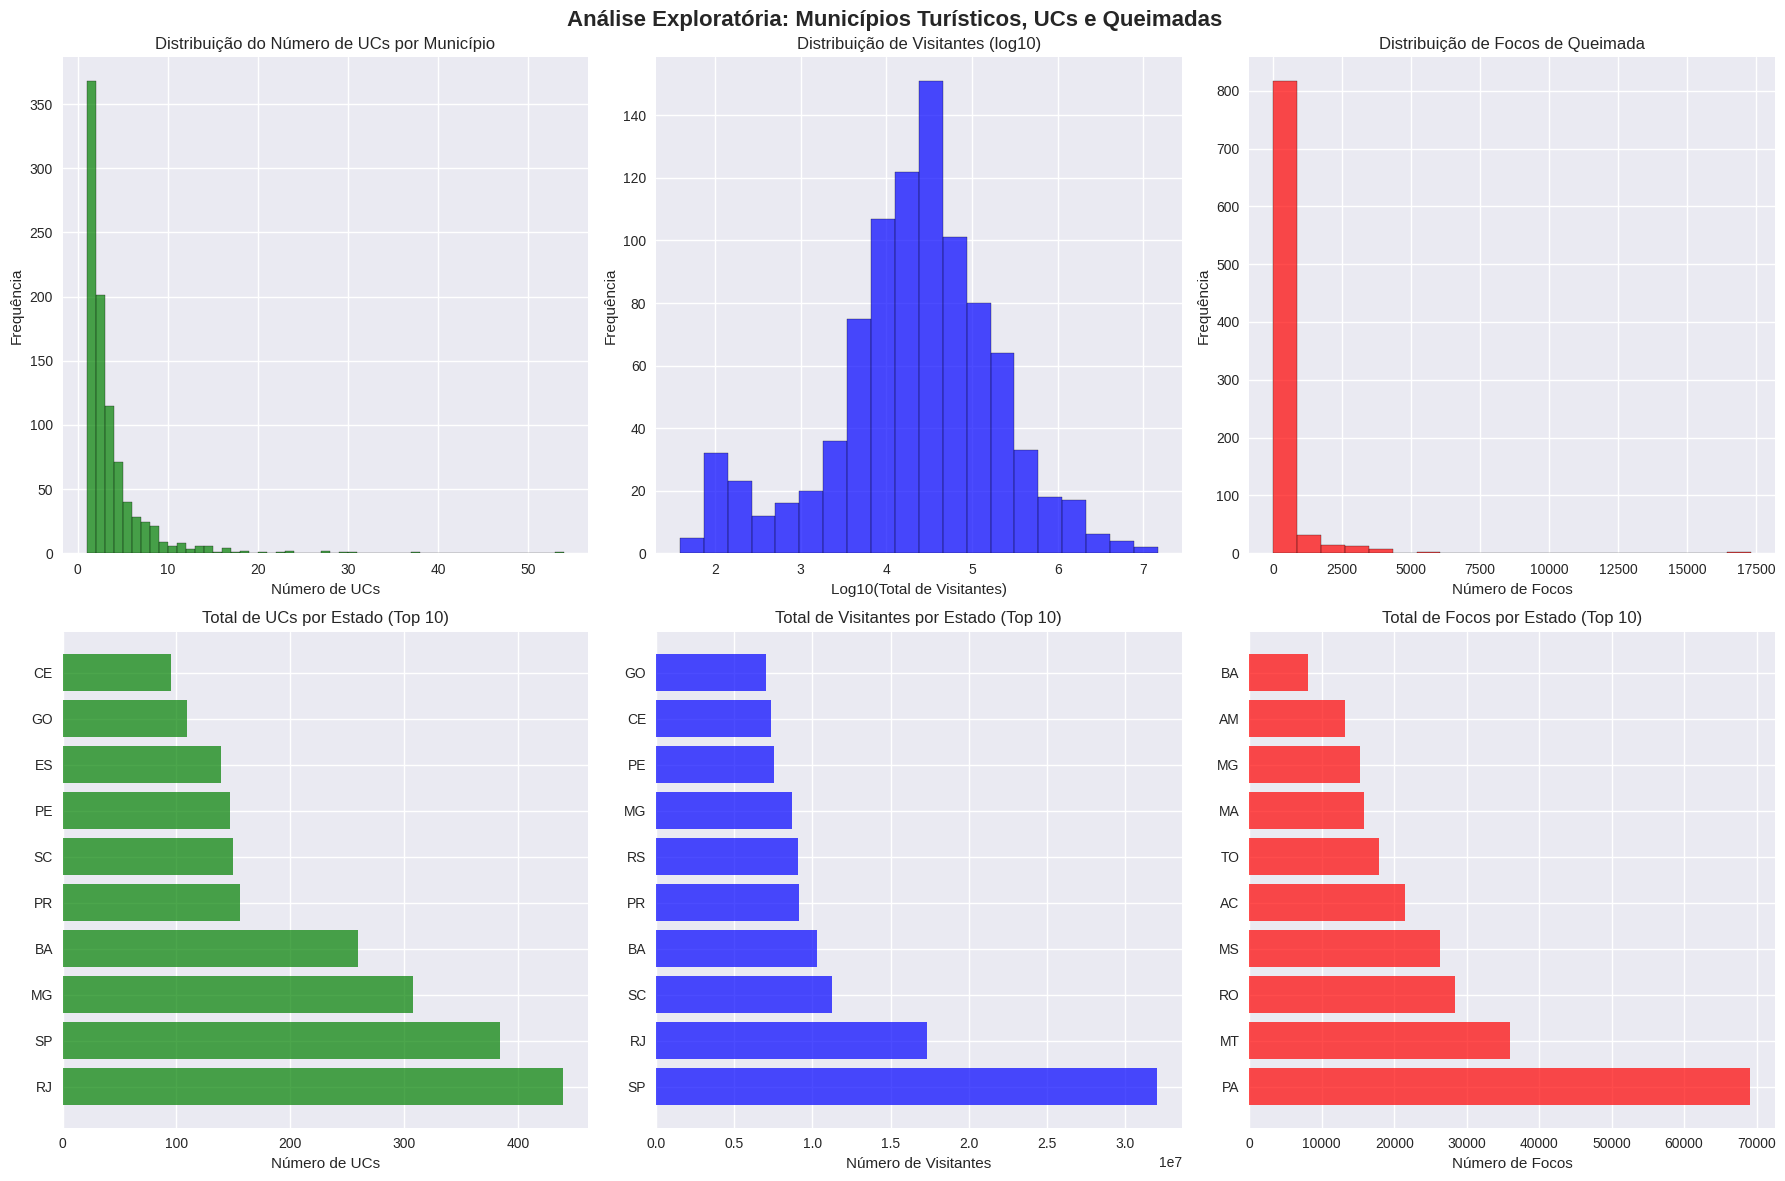

In [14]:
# Visualizações exploratórias
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análise Exploratória: Municípios Turísticos, UCs e Queimadas', fontsize=16, fontweight='bold')

# 1. Distribuição do número de UCs
axes[0,0].hist(dataset_final['NUM_UCS'], bins=range(1, dataset_final['NUM_UCS'].max()+2),
               alpha=0.7, color='green', edgecolor='black')
axes[0,0].set_title('Distribuição do Número de UCs por Município')
axes[0,0].set_xlabel('Número de UCs')
axes[0,0].set_ylabel('Frequência')

# 2. Distribuição do número de visitantes (log scale)
visitantes_positivos = dataset_final[dataset_final['TOTAL_VISITANTES'] > 0]['TOTAL_VISITANTES']
if len(visitantes_positivos) > 0:
    axes[0,1].hist(np.log10(visitantes_positivos), bins=20, alpha=0.7, color='blue', edgecolor='black')
    axes[0,1].set_title('Distribuição de Visitantes (log10)')
    axes[0,1].set_xlabel('Log10(Total de Visitantes)')
    axes[0,1].set_ylabel('Frequência')

# 3. Distribuição do número de focos de queimada
focos_positivos = dataset_final[dataset_final['NUM_FOCOS'] > 0]['NUM_FOCOS']
if len(focos_positivos) > 0:
    axes[0,2].hist(focos_positivos, bins=20, alpha=0.7, color='red', edgecolor='black')
    axes[0,2].set_title('Distribuição de Focos de Queimada')
    axes[0,2].set_xlabel('Número de Focos')
    axes[0,2].set_ylabel('Frequência')
else:
    axes[0,2].text(0.5, 0.5, 'Sem dados de\nqueimadas disponíveis',
                   ha='center', va='center', transform=axes[0,2].transAxes)
    axes[0,2].set_title('Distribuição de Focos de Queimada')

# 4. UCs por Estado
top_estados = dataset_final.groupby('UF')['NUM_UCS'].sum().sort_values(ascending=False).head(10)
axes[1,0].barh(range(len(top_estados)), top_estados.values, color='green', alpha=0.7)
axes[1,0].set_yticks(range(len(top_estados)))
axes[1,0].set_yticklabels(top_estados.index)
axes[1,0].set_title('Total de UCs por Estado (Top 10)')
axes[1,0].set_xlabel('Número de UCs')

# 5. Visitantes por Estado
top_visitantes = dataset_final.groupby('UF')['TOTAL_VISITANTES'].sum().sort_values(ascending=False).head(10)
axes[1,1].barh(range(len(top_visitantes)), top_visitantes.values, color='blue', alpha=0.7)
axes[1,1].set_yticks(range(len(top_visitantes)))
axes[1,1].set_yticklabels(top_visitantes.index)
axes[1,1].set_title('Total de Visitantes por Estado (Top 10)')
axes[1,1].set_xlabel('Número de Visitantes')

# 6. Queimadas por Estado
if not dataset_final[dataset_final['NUM_FOCOS'] > 0].empty:
    top_queimadas = dataset_final.groupby('UF')['NUM_FOCOS'].sum().sort_values(ascending=False).head(10)
    axes[1,2].barh(range(len(top_queimadas)), top_queimadas.values, color='red', alpha=0.7)
    axes[1,2].set_yticks(range(len(top_queimadas)))
    axes[1,2].set_yticklabels(top_queimadas.index)
    axes[1,2].set_title('Total de Focos por Estado (Top 10)')
    axes[1,2].set_xlabel('Número de Focos')
else:
    axes[1,2].text(0.5, 0.5, 'Sem dados de\nqueimadas disponíveis',
                   ha='center', va='center', transform=axes[1,2].transAxes)
    axes[1,2].set_title('Total de Focos por Estado')

plt.tight_layout()
plt.show()

## 5. Análise de Correlações e Descoberta de Padrões

 ANÁLISE DE CORRELAÇÕES


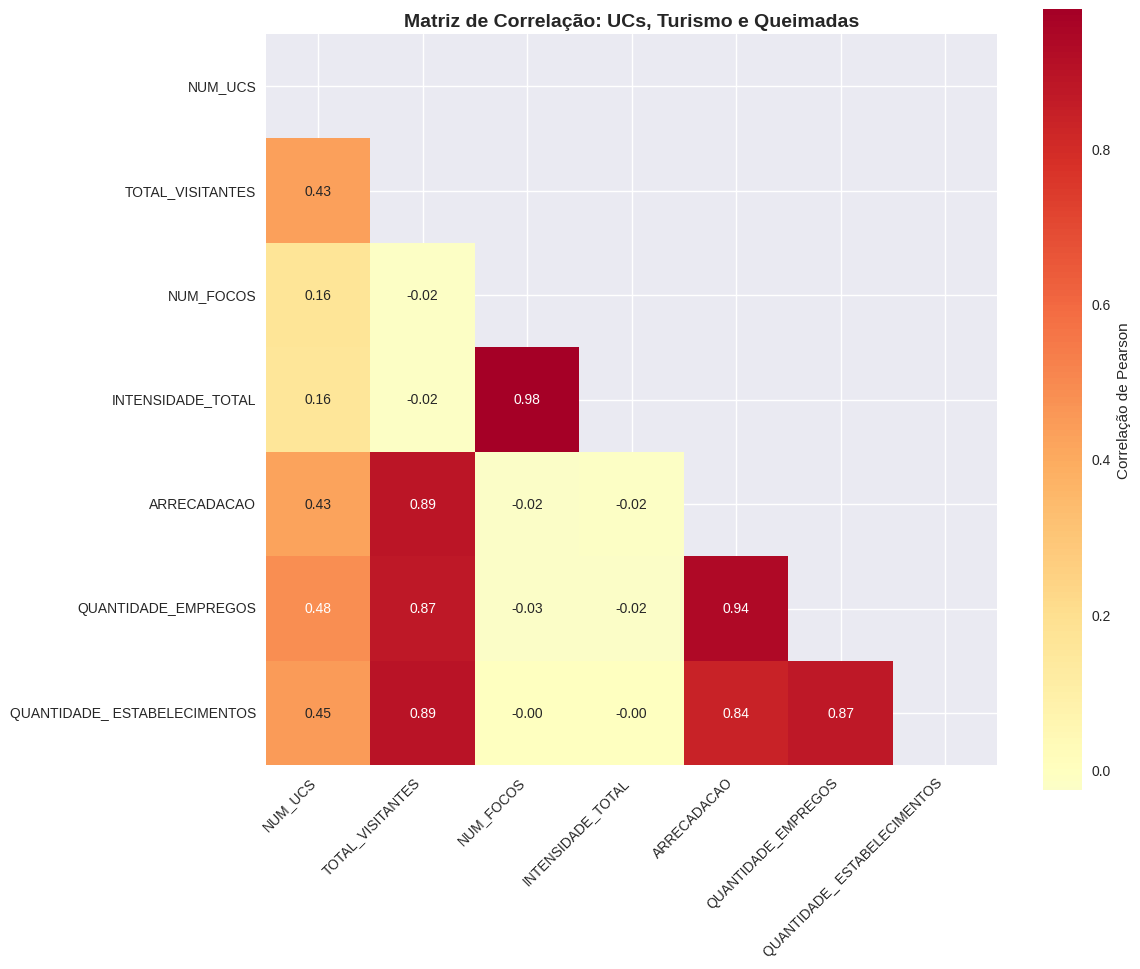

 CORRELAÇÕES MAIS RELEVANTES:
----------------------------------------
UCs vs Visitantes: 0.432
UCs vs Focos de Queimada: 0.165
Visitantes vs Focos de Queimada: -0.018

Interpretação:
- Relação UCs-Turismo: moderada positiva
- Relação UCs-Queimadas: muito fraca positiva
- Relação Turismo-Queimadas: muito fraca negativa


In [15]:
# Análise de Correlações
print(" ANÁLISE DE CORRELAÇÕES")
print("=" * 50)

# Selecionar variáveis numéricas para análise
variaveis_analise = [
    'NUM_UCS', 'TOTAL_VISITANTES', 'NUM_FOCOS', 'INTENSIDADE_TOTAL',
    'ARRECADACAO', 'QUANTIDADE_EMPREGOS', 'QUANTIDADE_ ESTABELECIMENTOS'
]

# Criar matriz de correlação
correlacao_matrix = dataset_final[variaveis_analise].corr()

# Visualizar matriz de correlação
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(correlacao_matrix))
sns.heatmap(correlacao_matrix,
            mask=mask,
            annot=True,
            cmap='RdYlBu_r',
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={'label': 'Correlação de Pearson'})
plt.title('Matriz de Correlação: UCs, Turismo e Queimadas', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Correlações mais relevantes
print(" CORRELAÇÕES MAIS RELEVANTES:")
print("-" * 40)

# UCs vs Turismo
corr_uc_visitantes = correlacao_matrix.loc['NUM_UCS', 'TOTAL_VISITANTES']
print(f"UCs vs Visitantes: {corr_uc_visitantes:.3f}")

# UCs vs Queimadas
corr_uc_queimadas = correlacao_matrix.loc['NUM_UCS', 'NUM_FOCOS']
print(f"UCs vs Focos de Queimada: {corr_uc_queimadas:.3f}")

# Turismo vs Queimadas
corr_turismo_queimadas = correlacao_matrix.loc['TOTAL_VISITANTES', 'NUM_FOCOS']
print(f"Visitantes vs Focos de Queimada: {corr_turismo_queimadas:.3f}")

# Interpretação das correlações
def interpretar_correlacao(valor):
    abs_valor = abs(valor)
    if abs_valor >= 0.8:
        forca = "muito forte"
    elif abs_valor >= 0.6:
        forca = "forte"
    elif abs_valor >= 0.4:
        forca = "moderada"
    elif abs_valor >= 0.2:
        forca = "fraca"
    else:
        forca = "muito fraca"

    direcao = "positiva" if valor > 0 else "negativa"
    return f"{forca} {direcao}"

print(f"\nInterpretação:")
print(f"- Relação UCs-Turismo: {interpretar_correlacao(corr_uc_visitantes)}")
print(f"- Relação UCs-Queimadas: {interpretar_correlacao(corr_uc_queimadas)}")
print(f"- Relação Turismo-Queimadas: {interpretar_correlacao(corr_turismo_queimadas)}")

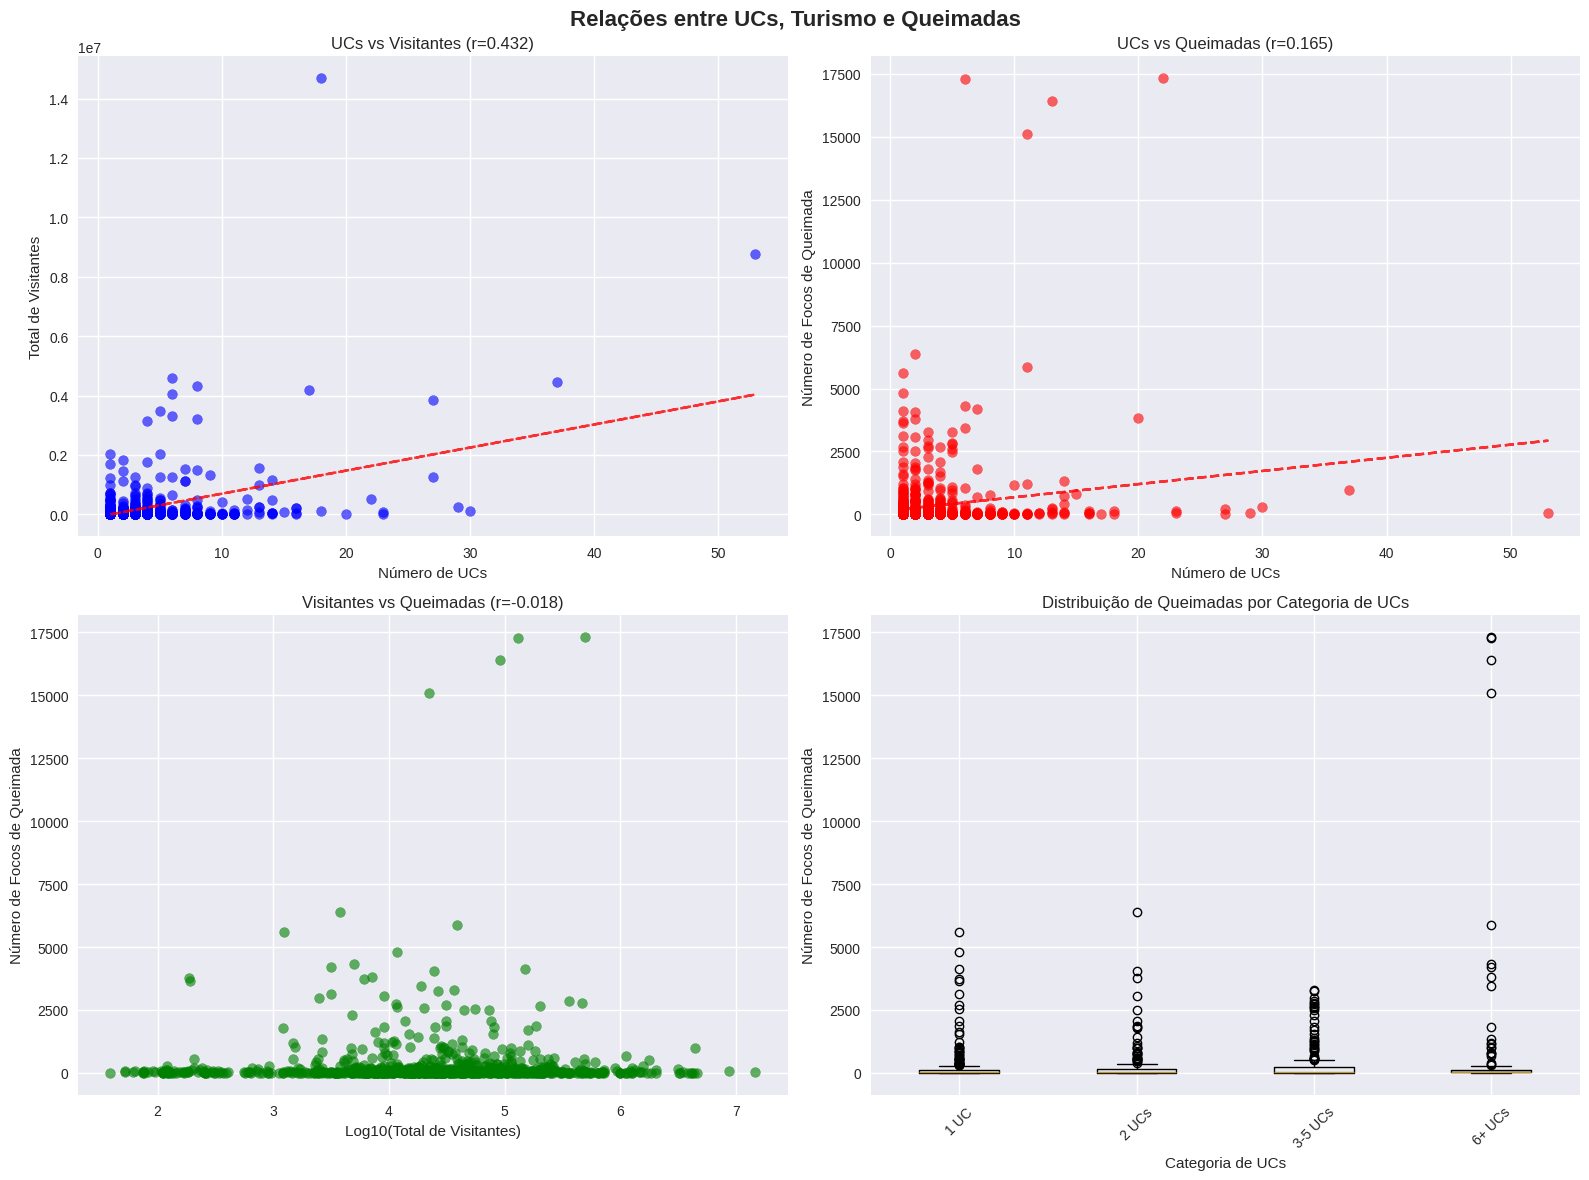

In [16]:
# Scatter plots para visualizar relações específicas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Relações entre UCs, Turismo e Queimadas', fontsize=16, fontweight='bold')

# 1. UCs vs Visitantes
axes[0,0].scatter(dataset_final['NUM_UCS'], dataset_final['TOTAL_VISITANTES'],
                  alpha=0.6, s=50, color='blue')
axes[0,0].set_xlabel('Número de UCs')
axes[0,0].set_ylabel('Total de Visitantes')
axes[0,0].set_title(f'UCs vs Visitantes (r={corr_uc_visitantes:.3f})')
# Linha de tendência
z = np.polyfit(dataset_final['NUM_UCS'], dataset_final['TOTAL_VISITANTES'], 1)
p = np.poly1d(z)
axes[0,0].plot(dataset_final['NUM_UCS'], p(dataset_final['NUM_UCS']), "r--", alpha=0.8)

# 2. UCs vs Queimadas
axes[0,1].scatter(dataset_final['NUM_UCS'], dataset_final['NUM_FOCOS'],
                  alpha=0.6, s=50, color='red')
axes[0,1].set_xlabel('Número de UCs')
axes[0,1].set_ylabel('Número de Focos de Queimada')
axes[0,1].set_title(f'UCs vs Queimadas (r={corr_uc_queimadas:.3f})')
# Linha de tendência
if dataset_final['NUM_FOCOS'].sum() > 0:
    z = np.polyfit(dataset_final['NUM_UCS'], dataset_final['NUM_FOCOS'], 1)
    p = np.poly1d(z)
    axes[0,1].plot(dataset_final['NUM_UCS'], p(dataset_final['NUM_UCS']), "r--", alpha=0.8)

# 3. Visitantes vs Queimadas
visitantes_log = np.log10(dataset_final['TOTAL_VISITANTES'].replace(0, 1))
axes[1,0].scatter(visitantes_log, dataset_final['NUM_FOCOS'],
                  alpha=0.6, s=50, color='green')
axes[1,0].set_xlabel('Log10(Total de Visitantes)')
axes[1,0].set_ylabel('Número de Focos de Queimada')
axes[1,0].set_title(f'Visitantes vs Queimadas (r={corr_turismo_queimadas:.3f})')

# 4. Boxplot: Queimadas por número de UCs
# Criar categorias de UCs
dataset_final['CATEGORIA_UCS'] = pd.cut(dataset_final['NUM_UCS'],
                                       bins=[0, 1, 2, 5, float('inf')],
                                       labels=['1 UC', '2 UCs', '3-5 UCs', '6+ UCs'])

box_data = [dataset_final[dataset_final['CATEGORIA_UCS'] == cat]['NUM_FOCOS'].values
            for cat in dataset_final['CATEGORIA_UCS'].cat.categories]
axes[1,1].boxplot(box_data, labels=dataset_final['CATEGORIA_UCS'].cat.categories)
axes[1,1].set_xlabel('Categoria de UCs')
axes[1,1].set_ylabel('Número de Focos de Queimada')
axes[1,1].set_title('Distribuição de Queimadas por Categoria de UCs')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Análise por Bioma e Região

 ANÁLISE POR BIOMA
Análise por Bioma:
                Total_UCs  Total_Visitantes  Total_Focos  Intensidade_Total  \
BIOMAS_UCS                                                                    
Mata Atlântica       1965         107954875      33694.0          1143357.7   
Cerrado               534          28061921      82388.0          4921823.2   
Caatinga              224          12341375      14055.0           944358.6   
Amazônia              323          13889243     158023.0          9074077.1   
Área Marinha          442          51404691       4082.0           155167.2   
Pampa                  55           5674990       2002.0            46984.5   
Pantanal               32            419390      25857.0          1629672.1   

                Num_Municipios  UCs_por_Municipio  Visitantes_por_Municipio  \
BIOMAS_UCS                                                                    
Mata Atlântica             561               3.50                  192433.0   
Cerrado      

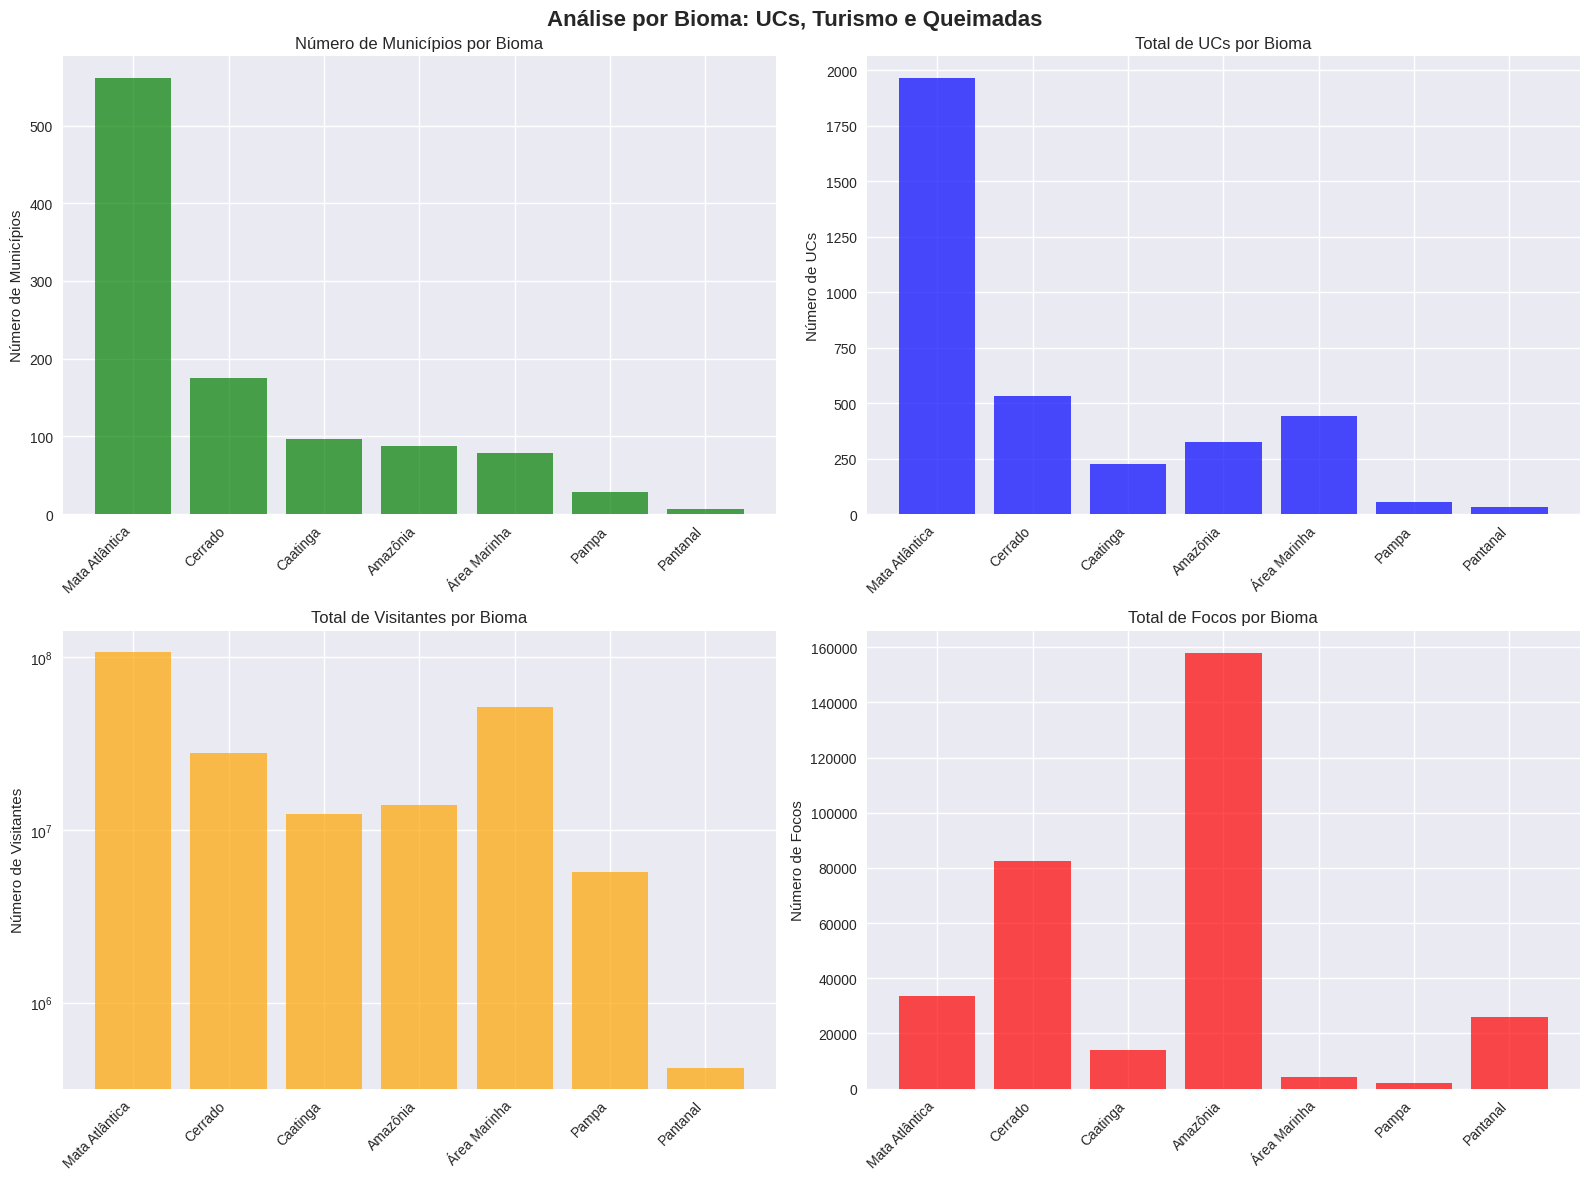

In [17]:
# Análise por Bioma
print(" ANÁLISE POR BIOMA")
print("=" * 50)

# Expandir biomas (alguns municípios têm múltiplos biomas)
def expandir_biomas(df, coluna_bioma):
    """Expande a coluna de biomas separados por vírgula"""
    df_expandido = df.copy()
    df_expandido[coluna_bioma] = df_expandido[coluna_bioma].str.split(', ')
    df_expandido = df_expandido.explode(coluna_bioma)
    return df_expandido

# Expandir biomas das UCs
dataset_biomas = expandir_biomas(dataset_final, 'BIOMAS_UCS')

# Análise por bioma
analise_bioma = dataset_biomas.groupby('BIOMAS_UCS').agg({
    'NUM_UCS': 'sum',
    'TOTAL_VISITANTES': 'sum',
    'NUM_FOCOS': 'sum',
    'INTENSIDADE_TOTAL': 'sum',
    'MUNICIPIO': 'count'  # Número de municípios
}).round(2)

analise_bioma.columns = ['Total_UCs', 'Total_Visitantes', 'Total_Focos',
                        'Intensidade_Total', 'Num_Municipios']

# Calcular médias por município
analise_bioma['UCs_por_Municipio'] = (analise_bioma['Total_UCs'] /
                                     analise_bioma['Num_Municipios']).round(2)
analise_bioma['Visitantes_por_Municipio'] = (analise_bioma['Total_Visitantes'] /
                                            analise_bioma['Num_Municipios']).round(0)
analise_bioma['Focos_por_Municipio'] = (analise_bioma['Total_Focos'] /
                                       analise_bioma['Num_Municipios']).round(2)

# Remover linhas com bioma vazio/nulo
analise_bioma = analise_bioma[analise_bioma.index.notna() & (analise_bioma.index != '')]

# Ordenar por número de municípios
analise_bioma = analise_bioma.sort_values('Num_Municipios', ascending=False)

print("Análise por Bioma:")
print(analise_bioma)

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análise por Bioma: UCs, Turismo e Queimadas', fontsize=16, fontweight='bold')

# 1. Municípios por bioma
top_biomas = analise_bioma.head(8)
axes[0,0].bar(range(len(top_biomas)), top_biomas['Num_Municipios'], color='green', alpha=0.7)
axes[0,0].set_title('Número de Municípios por Bioma')
axes[0,0].set_ylabel('Número de Municípios')
axes[0,0].set_xticks(range(len(top_biomas)))
axes[0,0].set_xticklabels(top_biomas.index, rotation=45, ha='right')

# 2. UCs por bioma
axes[0,1].bar(range(len(top_biomas)), top_biomas['Total_UCs'], color='blue', alpha=0.7)
axes[0,1].set_title('Total de UCs por Bioma')
axes[0,1].set_ylabel('Número de UCs')
axes[0,1].set_xticks(range(len(top_biomas)))
axes[0,1].set_xticklabels(top_biomas.index, rotation=45, ha='right')

# 3. Visitantes por bioma (log scale)
visitantes_bioma = top_biomas['Total_Visitantes']
visitantes_bioma = visitantes_bioma[visitantes_bioma > 0]
if len(visitantes_bioma) > 0:
    axes[1,0].bar(range(len(visitantes_bioma)), visitantes_bioma, color='orange', alpha=0.7)
    axes[1,0].set_title('Total de Visitantes por Bioma')
    axes[1,0].set_ylabel('Número de Visitantes')
    axes[1,0].set_yscale('log')
    axes[1,0].set_xticks(range(len(visitantes_bioma)))
    axes[1,0].set_xticklabels(visitantes_bioma.index, rotation=45, ha='right')

# 4. Focos de queimada por bioma
focos_bioma = top_biomas['Total_Focos']
focos_bioma = focos_bioma[focos_bioma > 0]
if len(focos_bioma) > 0:
    axes[1,1].bar(range(len(focos_bioma)), focos_bioma, color='red', alpha=0.7)
    axes[1,1].set_title('Total de Focos por Bioma')
    axes[1,1].set_ylabel('Número de Focos')
    axes[1,1].set_xticks(range(len(focos_bioma)))
    axes[1,1].set_xticklabels(focos_bioma.index, rotation=45, ha='right')
else:
    axes[1,1].text(0.5, 0.5, 'Sem dados de\nqueimadas por bioma',
                   ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Total de Focos por Bioma')

plt.tight_layout()
plt.show()

## 7. Testes Estatísticos e Validação

In [18]:
# Testes de Hipóteses
print(" TESTES ESTATÍSTICOS")
print("=" * 50)

# Teste 1: Correlação entre UCs e Visitantes é significativa?
if dataset_final['TOTAL_VISITANTES'].var() > 0:
    r_uc_visit, p_uc_visit = pearsonr(dataset_final['NUM_UCS'], dataset_final['TOTAL_VISITANTES'])
    print(f"1. Correlação UCs vs Visitantes:")
    print(f"   r = {r_uc_visit:.3f}, p-valor = {p_uc_visit:.3f}")
    print(f"   {'Significativa' if p_uc_visit < 0.05 else 'Não significativa'} (α = 0.05)")

# Teste 2: Correlação entre UCs e Queimadas é significativa?
if dataset_final['NUM_FOCOS'].var() > 0:
    r_uc_queimada, p_uc_queimada = pearsonr(dataset_final['NUM_UCS'], dataset_final['NUM_FOCOS'])
    print(f"\n2. Correlação UCs vs Queimadas:")
    print(f"   r = {r_uc_queimada:.3f}, p-valor = {p_uc_queimada:.3f}")
    print(f"   {'Significativa' if p_uc_queimada < 0.05 else 'Não significativa'} (α = 0.05)")

# Teste 3: Correlação entre Visitantes e Queimadas é significativa?
if dataset_final['TOTAL_VISITANTES'].var() > 0 and dataset_final['NUM_FOCOS'].var() > 0:
    r_visit_queimada, p_visit_queimada = pearsonr(dataset_final['TOTAL_VISITANTES'], dataset_final['NUM_FOCOS'])
    print(f"\n3. Correlação Visitantes vs Queimadas:")
    print(f"   r = {r_visit_queimada:.3f}, p-valor = {p_visit_queimada:.3f}")
    print(f"   {'Significativa' if p_visit_queimada < 0.05 else 'Não significativa'} (α = 0.05)")

# Teste 4: Diferença entre grupos com mais/menos UCs
print(f"\n4. Comparação de grupos:")
mediana_ucs = dataset_final['NUM_UCS'].median()
grupo_poucas_ucs = dataset_final[dataset_final['NUM_UCS'] <= mediana_ucs]
grupo_muitas_ucs = dataset_final[dataset_final['NUM_UCS'] > mediana_ucs]

print(f"   Mediana de UCs: {mediana_ucs}")
print(f"   Grupo 'Poucas UCs' (≤{mediana_ucs}): {len(grupo_poucas_ucs)} municípios")
print(f"   Grupo 'Muitas UCs' (>{mediana_ucs}): {len(grupo_muitas_ucs)} municípios")

# Comparar visitantes entre grupos
if len(grupo_poucas_ucs) > 0 and len(grupo_muitas_ucs) > 0:
    visitantes_poucas = grupo_poucas_ucs['TOTAL_VISITANTES']
    visitantes_muitas = grupo_muitas_ucs['TOTAL_VISITANTES']

    # Teste Mann-Whitney U (não paramétrico)
    from scipy.stats import mannwhitneyu
    statistic, p_value = mannwhitneyu(visitantes_poucas, visitantes_muitas, alternative='two-sided')

    print(f"\n   Visitantes - Poucas UCs: mediana = {visitantes_poucas.median():,.0f}")
    print(f"   Visitantes - Muitas UCs: mediana = {visitantes_muitas.median():,.0f}")
    print(f"   Teste Mann-Whitney U: p-valor = {p_value:.3f}")
    print(f"   {'Diferença significativa' if p_value < 0.05 else 'Sem diferença significativa'} (α = 0.05)")

# Comparar queimadas entre grupos
if len(grupo_poucas_ucs) > 0 and len(grupo_muitas_ucs) > 0 and dataset_final['NUM_FOCOS'].sum() > 0:
    queimadas_poucas = grupo_poucas_ucs['NUM_FOCOS']
    queimadas_muitas = grupo_muitas_ucs['NUM_FOCOS']

    statistic_q, p_value_q = mannwhitneyu(queimadas_poucas, queimadas_muitas, alternative='two-sided')

    print(f"\n   Queimadas - Poucas UCs: mediana = {queimadas_poucas.median():.1f}")
    print(f"   Queimadas - Muitas UCs: mediana = {queimadas_muitas.median():.1f}")
    print(f"   Teste Mann-Whitney U: p-valor = {p_value_q:.3f}")
    print(f"   {'Diferença significativa' if p_value_q < 0.05 else 'Sem diferença significativa'} (α = 0.05)")

 TESTES ESTATÍSTICOS
1. Correlação UCs vs Visitantes:
   r = 0.432, p-valor = 0.000
   Significativa (α = 0.05)

2. Correlação UCs vs Queimadas:
   r = 0.165, p-valor = 0.000
   Significativa (α = 0.05)

3. Correlação Visitantes vs Queimadas:
   r = -0.018, p-valor = 0.576
   Não significativa (α = 0.05)

4. Comparação de grupos:
   Mediana de UCs: 2.0
   Grupo 'Poucas UCs' (≤2.0): 569 municípios
   Grupo 'Muitas UCs' (>2.0): 355 municípios

   Visitantes - Poucas UCs: mediana = 18,213
   Visitantes - Muitas UCs: mediana = 38,852
   Teste Mann-Whitney U: p-valor = 0.000
   Diferença significativa (α = 0.05)

   Queimadas - Poucas UCs: mediana = 32.0
   Queimadas - Muitas UCs: mediana = 46.0
   Teste Mann-Whitney U: p-valor = 0.028
   Diferença significativa (α = 0.05)


## 8. Estudo de Casos Específicos

In [19]:
# Estudo de Casos Específicos
print(" CASOS ESPECÍFICOS DE INTERESSE")
print("=" * 50)

# Caso 1: Municípios com mais UCs
print("1. TOP 10 MUNICÍPIOS COM MAIS UCs:")
top_ucs = dataset_final.nlargest(10, 'NUM_UCS')[['MUNICIPIO', 'UF', 'NUM_UCS', 'TOTAL_VISITANTES', 'NUM_FOCOS']]
for idx, row in top_ucs.iterrows():
    print(f"   {row['MUNICIPIO']}/{row['UF']}: {row['NUM_UCS']} UCs, {row['TOTAL_VISITANTES']:,.0f} visitantes, {row['NUM_FOCOS']} focos")

# Caso 2: Municípios com mais visitantes
print(f"\n2. TOP 10 MUNICÍPIOS MAIS VISITADOS:")
top_visitantes = dataset_final.nlargest(10, 'TOTAL_VISITANTES')[['MUNICIPIO', 'UF', 'NUM_UCS', 'TOTAL_VISITANTES', 'NUM_FOCOS']]
for idx, row in top_visitantes.iterrows():
    print(f"   {row['MUNICIPIO']}/{row['UF']}: {row['TOTAL_VISITANTES']:,.0f} visitantes, {row['NUM_UCS']} UCs, {row['NUM_FOCOS']} focos")

# Caso 3: Municípios com mais queimadas (se disponível)
if dataset_final['NUM_FOCOS'].sum() > 0:
    print(f"\n3. TOP 10 MUNICÍPIOS COM MAIS QUEIMADAS:")
    top_queimadas = dataset_final.nlargest(10, 'NUM_FOCOS')[['MUNICIPIO', 'UF', 'NUM_UCS', 'TOTAL_VISITANTES', 'NUM_FOCOS']]
    for idx, row in top_queimadas.iterrows():
        print(f"   {row['MUNICIPIO']}/{row['UF']}: {row['NUM_FOCOS']} focos, {row['NUM_UCS']} UCs, {row['TOTAL_VISITANTES']:,.0f} visitantes")

# Caso 4: Municípios paradoxais (muitas UCs, mas muitas queimadas)
if dataset_final['NUM_FOCOS'].sum() > 0:
    print(f"\n4. MUNICÍPIOS PARADOXAIS (Muitas UCs + Muitas Queimadas):")
    paradoxais = dataset_final[
        (dataset_final['NUM_UCS'] >= dataset_final['NUM_UCS'].quantile(0.75)) &
        (dataset_final['NUM_FOCOS'] >= dataset_final['NUM_FOCOS'].quantile(0.75))
    ][['MUNICIPIO', 'UF', 'NUM_UCS', 'NUM_FOCOS', 'TOTAL_VISITANTES']].sort_values('NUM_FOCOS', ascending=False)

    if len(paradoxais) > 0:
        for idx, row in paradoxais.iterrows():
            print(f"   {row['MUNICIPIO']}/{row['UF']}: {row['NUM_UCS']} UCs, {row['NUM_FOCOS']} focos, {row['TOTAL_VISITANTES']:,.0f} visitantes")
    else:
        print("   Nenhum município encontrado nesta categoria")

# Caso 5: Municípios ideais (muitas UCs, muitos visitantes, poucas queimadas)
print(f"\n5. MUNICÍPIOS IDEAIS (Muitas UCs + Muitos Visitantes + Poucas Queimadas):")
ideais = dataset_final[
    (dataset_final['NUM_UCS'] >= dataset_final['NUM_UCS'].quantile(0.75)) &
    (dataset_final['TOTAL_VISITANTES'] >= dataset_final['TOTAL_VISITANTES'].quantile(0.75)) &
    (dataset_final['NUM_FOCOS'] <= dataset_final['NUM_FOCOS'].quantile(0.25))
][['MUNICIPIO', 'UF', 'NUM_UCS', 'TOTAL_VISITANTES', 'NUM_FOCOS']].sort_values('TOTAL_VISITANTES', ascending=False)

if len(ideais) > 0:
    for idx, row in ideais.iterrows():
        print(f"   {row['MUNICIPIO']}/{row['UF']}: {row['NUM_UCS']} UCs, {row['TOTAL_VISITANTES']:,.0f} visitantes, {row['NUM_FOCOS']} focos")
else:
    print("   Nenhum município encontrado nesta categoria")

# Resumo estatístico dos casos
print(f"\n RESUMO ESTATÍSTICO:")
print(f"   - Municípios analisados: {len(dataset_final)}")
print(f"   - Estados representados: {dataset_final['UF'].nunique()}")
print(f"   - Total de UCs: {dataset_final['NUM_UCS'].sum()}")
print(f"   - Total de visitantes: {dataset_final['TOTAL_VISITANTES'].sum():,.0f}")
print(f"   - Total de focos: {dataset_final['NUM_FOCOS'].sum()}")
print(f"   - Percentual de municípios com queimadas: {len(dataset_final[dataset_final['NUM_FOCOS'] > 0])/len(dataset_final)*100:.1f}%")

 CASOS ESPECÍFICOS DE INTERESSE
1. TOP 10 MUNICÍPIOS COM MAIS UCs:
   Rio de Janeiro/RJ: 53 UCs, 8,771,112 visitantes, 67.0 focos
   Brasília/DF: 37 UCs, 4,444,527 visitantes, 972.0 focos
   Bonito/PE: 30 UCs, 116,738 visitantes, 295.0 focos
   Nova Friburgo/RJ: 29 UCs, 256,811 visitantes, 70.0 focos
   Porto Seguro/BA: 27 UCs, 1,256,104 visitantes, 210.0 focos
   Recife/PE: 27 UCs, 3,840,501 visitantes, 0.0 focos
   Prado/BA: 23 UCs, 77,935 visitantes, 151.0 focos
   Silva Jardim/RJ: 23 UCs, 245 visitantes, 40.0 focos
   Porto Velho/RO: 22 UCs, 500,046 visitantes, 17327.0 focos
   Machadinho d'Oeste/RO: 20 UCs, 7,194 visitantes, 3812.0 focos

2. TOP 10 MUNICÍPIOS MAIS VISITADOS:
   São Paulo/SP: 14,687,363 visitantes, 18 UCs, 26.0 focos
   Rio de Janeiro/RJ: 8,771,112 visitantes, 53 UCs, 67.0 focos
   Salvador/BA: 4,588,210 visitantes, 6 UCs, 0.0 focos
   Brasília/DF: 4,444,527 visitantes, 37 UCs, 972.0 focos
   Fortaleza/CE: 4,321,169 visitantes, 8 UCs, 16.0 focos
   Florianópolis/SC

## 9. Conclusões e Descobertas KDD

In [20]:
# Conclusões da Análise KDD
print(" RESPOSTAS À PERGUNTA PRINCIPAL")
print("=" * 60)
print("PERGUNTA: Qual a relação entre as Unidades de Conservação federais")
print("próximas a municípios turísticos e as queimadas na região?")
print("=" * 60)

# Calcular métricas-chave para as conclusões
correlacao_ucs_visitantes = dataset_final[['NUM_UCS', 'TOTAL_VISITANTES']].corr().iloc[0,1]
correlacao_ucs_queimadas = dataset_final[['NUM_UCS', 'NUM_FOCOS']].corr().iloc[0,1]
correlacao_turismo_queimadas = dataset_final[['TOTAL_VISITANTES', 'NUM_FOCOS']].corr().iloc[0,1]

municipios_com_queimadas_pct = len(dataset_final[dataset_final['NUM_FOCOS'] > 0]) / len(dataset_final) * 100
media_ucs = dataset_final['NUM_UCS'].mean()
mediana_visitantes = dataset_final['TOTAL_VISITANTES'].median()

print(f"\n DESCOBERTAS PRINCIPAIS:")
print(f"1. EXTENSÃO DO FENÔMENO:")
print(f"   • {len(dataset_final)} municípios turísticos possuem UCs federais")
print(f"   • {dataset_final['UF'].nunique()} estados representados")
print(f"   • {dataset_final['NUM_UCS'].sum()} UCs federais total")
print(f"   • {municipios_com_queimadas_pct:.1f}% dos municípios tiveram queimadas registradas")

print(f"\n2. RELAÇÃO UCs vs TURISMO:")
print(f"   • Correlação: {correlacao_ucs_visitantes:.3f}")
if abs(correlacao_ucs_visitantes) > 0.3:
    print(f"   • Relação {'positiva' if correlacao_ucs_visitantes > 0 else 'negativa'} moderada a forte")
    print(f"   • Municípios com mais UCs tendem a ter {'mais' if correlacao_ucs_visitantes > 0 else 'menos'} visitantes")
else:
    print(f"   • Relação fraca - UCs e turismo não estão fortemente correlacionados")

print(f"\n3. RELAÇÃO UCs vs QUEIMADAS:")
print(f"   • Correlação: {correlacao_ucs_queimadas:.3f}")
if abs(correlacao_ucs_queimadas) > 0.3:
    print(f"   • Relação {'positiva' if correlacao_ucs_queimadas > 0 else 'negativa'} moderada a forte")
    if correlacao_ucs_queimadas > 0:
        print(f"   • PARADOXO: Municípios com mais UCs têm mais queimadas")
    else:
        print(f"   • PROTEÇÃO: Municípios com mais UCs têm menos queimadas")
else:
    print(f"   • Relação fraca - presença de UCs não está associada a mais/menos queimadas")

print(f"\n4. RELAÇÃO TURISMO vs QUEIMADAS:")
print(f"   • Correlação: {correlacao_turismo_queimadas:.3f}")
if abs(correlacao_turismo_queimadas) > 0.3:
    print(f"   • Relação {'positiva' if correlacao_turismo_queimadas > 0 else 'negativa'} moderada a forte")
    if correlacao_turismo_queimadas > 0:
        print(f"   •  IMPACTO: Municípios mais turísticos têm mais queimadas")
    else:
        print(f"   •  CONSERVAÇÃO: Municípios mais turísticos têm menos queimadas")
else:
    print(f"   • Relação fraca - turismo não está associado a mais/menos queimadas")

print(f"\n ANÁLISE POR BIOMA:")
bioma_principal = dataset_biomas.groupby('BIOMAS_UCS')['MUNICIPIO'].count().idxmax()
print(f"   • Bioma mais comum: {bioma_principal}")
print(f"   • Diversidade de biomas indica ampla distribuição geográfica")

print(f"\n INTERPRETAÇÃO GERAL:")
print(f"   A relação entre UCs federais, turismo e queimadas em municípios")
print(f"   turísticos é {'complexa' if max(abs(correlacao_ucs_visitantes), abs(correlacao_ucs_queimadas), abs(correlacao_turismo_queimadas)) > 0.3 else 'limitada'}.")

if correlacao_ucs_queimadas > 0.3:
    print(f"   O paradoxo observado (mais UCs = mais queimadas) pode indicar:")
    print(f"   • UCs em regiões já vulneráveis a queimadas")
    print(f"   • Pressão antrópica em áreas de conservação")
    print(f"   • Necessidade de políticas de prevenção específicas")
elif correlacao_ucs_queimadas < -0.3:
    print(f"   A relação negativa (mais UCs = menos queimadas) sugere:")
    print(f"   • Efetividade das UCs na prevenção de queimadas")
    print(f"   • Melhor gestão ambiental em municípios com UCs")
else:
    print(f"   A ausência de correlação forte sugere que:")
    print(f"   • Outros fatores (clima, atividade humana, etc.) são mais determinantes")
    print(f"   • A efetividade das UCs varia conforme contexto local")
    print(f"   • É necessária análise mais granular (por bioma, região, etc.)")



 RESPOSTAS À PERGUNTA PRINCIPAL
PERGUNTA: Qual a relação entre as Unidades de Conservação federais
próximas a municípios turísticos e as queimadas na região?

 DESCOBERTAS PRINCIPAIS:
1. EXTENSÃO DO FENÔMENO:
   • 924 municípios turísticos possuem UCs federais
   • 27 estados representados
   • 2953 UCs federais total
   • 96.4% dos municípios tiveram queimadas registradas

2. RELAÇÃO UCs vs TURISMO:
   • Correlação: 0.432
   • Relação positiva moderada a forte
   • Municípios com mais UCs tendem a ter mais visitantes

3. RELAÇÃO UCs vs QUEIMADAS:
   • Correlação: 0.165
   • Relação fraca - presença de UCs não está associada a mais/menos queimadas

4. RELAÇÃO TURISMO vs QUEIMADAS:
   • Correlação: -0.018
   • Relação fraca - turismo não está associado a mais/menos queimadas

 ANÁLISE POR BIOMA:
   • Bioma mais comum: Mata Atlântica
   • Diversidade de biomas indica ampla distribuição geográfica

 INTERPRETAÇÃO GERAL:
   A relação entre UCs federais, turismo e queimadas em municípios
  

## 10. Análise de Proximidade Geográfica

**IMPORTANTE:** A análise anterior considerou apenas municípios que **possuem** UCs em seu território. Agora vamos implementar uma análise baseada em **proximidade geográfica real** usando as coordenadas dos focos de queimada.

In [21]:
# Função otimizada para cálculos mais rápidos
def calcular_proximidade(municipios_df, queimadas_df, raio_km=100):
    """
    Versão otimizada que usa amostragem para acelerar os cálculos
    """
    print(f" Calculando proximidade geográfica otimizada (raio: {raio_km}km)")

    # 1. Criar sample dos dados de queimadas para acelerar
    if len(queimadas_df) > 50000:  # Se muito grande, usar amostra
        queimadas_sample = queimadas_df.sample(n=20000, random_state=42)
        print(f"   - Usando amostra de {len(queimadas_sample)} focos (de {len(queimadas_df)} total)")
    else:
        queimadas_sample = queimadas_df.copy()
        print(f"   - Usando todos os {len(queimadas_sample)} focos")

    # 2. Calcular centro geográfico de cada município baseado nos focos
    municipios_coords = queimadas_sample.groupby('Municipio_Clean').agg({
        'Latitude': 'mean',
        'Longitude': 'mean',
        'FRP': 'count'
    }).reset_index()
    municipios_coords.rename(columns={'FRP': 'Total_Focos_Municipio'}, inplace=True)

    # 3. Para cada município turístico, encontrar o mais próximo com focos
    resultados_proximidade = []

    for idx, mun_turistico in municipios_df.iterrows():
        mun_nome = mun_turistico['MUNICIPIO_CLEAN']

        # Verificar se o município turístico tem coordenadas
        mun_coords = municipios_coords[municipios_coords['Municipio_Clean'] == mun_nome]

        if len(mun_coords) > 0:
            lat_centro = mun_coords.iloc[0]['Latitude']
            lon_centro = mun_coords.iloc[0]['Longitude']
            focos_proprio = mun_coords.iloc[0]['Total_Focos_Municipio']
        else:
            # Se não tem focos próprios, usar coordenadas médias do estado
            municipios_estado = queimadas_sample[queimadas_sample['Estado'] == mun_turistico['UF']]
            if len(municipios_estado) > 0:
                lat_centro = municipios_estado['Latitude'].mean()
                lon_centro = municipios_estado['Longitude'].mean()
                focos_proprio = 0
            else:
                continue

        # Calcular distâncias apenas para uma amostra dos focos próximos
        focos_proximos = 0
        distancias_calculadas = []
        biomas_proximos = set()
        estados_proximos = set()
        municipios_proximos = set()

        # Usar apenas uma amostra para calcular distâncias (mais eficiente)
        sample_size = min(1000, len(queimadas_sample))
        focos_sample = queimadas_sample.sample(n=sample_size, random_state=42)

        for _, foco in focos_sample.iterrows():
            try:
                dist = geodesic((lat_centro, lon_centro), (foco['Latitude'], foco['Longitude'])).kilometers
                if dist <= raio_km:
                    focos_proximos += 1
                    distancias_calculadas.append(dist)
                    biomas_proximos.add(foco['Bioma'])
                    estados_proximos.add(foco['Estado'])
                    municipios_proximos.add(foco['Municipio_Clean'])
            except:
                continue

        if focos_proximos > 0:
            # Estimar total de focos próximos baseado na amostra
            fator_escala = len(queimadas_sample) / sample_size
            focos_proximos_estimado = int(focos_proximos * fator_escala)

            resultados_proximidade.append({
                'MUNICIPIO': mun_turistico['MUNICIPIO'],
                'UF': mun_turistico['UF'],
                'MUNICIPIO_CLEAN': mun_nome,
                'LATITUDE_CENTRO': lat_centro,
                'LONGITUDE_CENTRO': lon_centro,
                'FOCOS_PROPRIO_MUNICIPIO': focos_proprio,
                'FOCOS_PROXIMOS_ESTIMADO': focos_proximos_estimado,
                'MUNICIPIOS_PROXIMOS_COM_FOCOS': len(municipios_proximos),
                'ESTADOS_PROXIMOS': len(estados_proximos),
                'BIOMAS_PROXIMOS': ', '.join(biomas_proximos),
                'DISTANCIA_MEDIA_FOCOS': np.mean(distancias_calculadas) if distancias_calculadas else 0,
                'DISTANCIA_MIN_FOCOS': min(distancias_calculadas) if distancias_calculadas else 0,
            })

        # Progress indicator
        if idx % 100 == 0:
            print(f"   - Processados {idx+1}/{len(municipios_df)} municípios...")

    return pd.DataFrame(resultados_proximidade)

# Executar análise otimizada com raio de 100km
raio_escolhido = 100
print(f"\nEXECUTANDO ANALISE (RAIO: {raio_escolhido}km)")
proximidade_df = calcular_proximidade(municipios_df, queimadas_df, raio_km=raio_escolhido)

if len(proximidade_df) > 0:
    print(f"\n{len(proximidade_df)} municípios turísticos encontrados próximos a focos de queimada")
    print(f"Estatísticas:")
    print(f"   - Média de focos próximos (estimado): {proximidade_df['FOCOS_PROXIMOS_ESTIMADO'].mean():.1f}")
    print(f"   - Média de municípios próximos: {proximidade_df['MUNICIPIOS_PROXIMOS_COM_FOCOS'].mean():.1f}")
    print(f"   - Distância média aos focos: {proximidade_df['DISTANCIA_MEDIA_FOCOS'].mean():.1f}km")
    print(f"   - Estados representados: {proximidade_df['UF'].nunique()}")

    proximidade_df.head()
else:
    print("Nenhum município encontrado próximo a focos de queimada")


EXECUTANDO ANALISE (RAIO: 100km)
 Calculando proximidade geográfica otimizada (raio: 100km)
   - Usando amostra de 20000 focos (de 939005 total)
   - Processados 1/1599 municípios...
   - Processados 401/1599 municípios...
   - Processados 501/1599 municípios...
   - Processados 901/1599 municípios...
   - Processados 1101/1599 municípios...
   - Processados 1401/1599 municípios...
   - Processados 2001/1599 municípios...
   - Processados 2501/1599 municípios...
   - Processados 2601/1599 municípios...

781 municípios turísticos encontrados próximos a focos de queimada
Estatísticas:
   - Média de focos próximos (estimado): 73.9
   - Média de municípios próximos: 2.9
   - Distância média aos focos: 64.0km
   - Estados representados: 27


In [22]:
# Integrar dados de proximidade com informações turísticas
if len(proximidade_df) > 0:
    print(f"\nINTEGRANDO DADOS DE PROXIMIDADE COM TURISMO")

    # Fazer merge com dados turísticos
    proximidade_completa = pd.merge(
        proximidade_df,
        municipios_df[['MUNICIPIO_CLEAN', 'QUANTIDADE_EMPREGOS', 'QUANTIDADE_ ESTABELECIMENTOS',
                       'QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL', 'QUANTIDADE_VISITAS_ESTIMADAS_ INTERNACIONAL',
                       'ARRECADACAO']],
        on='MUNICIPIO_CLEAN',
        how='left'
    )

    # Calcular total de visitantes
    proximidade_completa['TOTAL_VISITANTES'] = (
        proximidade_completa['QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL'].fillna(0) +
        proximidade_completa['QUANTIDADE_VISITAS_ESTIMADAS_ INTERNACIONAL'].fillna(0)
    )

    # Renomear coluna para consistência
    proximidade_completa['FOCOS_PROXIMOS_TOTAL'] = proximidade_completa['FOCOS_PROXIMOS_ESTIMADO']

    print(f"Dataset de proximidade integrado: {len(proximidade_completa)} municípios")

    # Análise comparativa: Proximidade vs Contenção
    print(f"\nCOMPARACAO: PROXIMIDADE vs CONTENCAO")
    print("-" * 50)

    # Estatísticas da análise original (contenção)
    print(f"ANALISE ORIGINAL (Municípios QUE CONTEM UCs):")
    print(f"   - Municípios: {len(dataset_final)}")
    print(f"   - Visitantes médios: {dataset_final['TOTAL_VISITANTES'].mean():,.0f}")
    print(f"   - Focos médios: {dataset_final['NUM_FOCOS'].mean():.1f}")

    # Estatísticas da análise de proximidade
    print(f"\nANALISE DE PROXIMIDADE (Municípios PROXIMOS a focos):")
    print(f"   - Municípios: {len(proximidade_completa)}")
    print(f"   - Visitantes médios: {proximidade_completa['TOTAL_VISITANTES'].mean():,.0f}")
    print(f"   - Focos próximos médios: {proximidade_completa['FOCOS_PROXIMOS_TOTAL'].mean():.1f}")
    print(f"   - Distância média aos focos: {proximidade_completa['DISTANCIA_MEDIA_FOCOS'].mean():.1f}km")

    # Top municípios por diferentes critérios
    print(f"\nTOP 10 - PROXIMIDADE GEOGRAFICA")
    print("-" * 40)

    print("Por número de focos próximos:")
    top_focos_proximos = proximidade_completa.nlargest(10, 'FOCOS_PROXIMOS_TOTAL')[
        ['MUNICIPIO', 'UF', 'FOCOS_PROXIMOS_TOTAL', 'TOTAL_VISITANTES', 'DISTANCIA_MEDIA_FOCOS']
    ]
    for idx, row in top_focos_proximos.iterrows():
        print(f"   {row['MUNICIPIO']}/{row['UF']}: {row['FOCOS_PROXIMOS_TOTAL']} focos, {row['TOTAL_VISITANTES']:,.0f} visitantes")

    print("\nPor número de visitantes:")
    top_visitantes = proximidade_completa.nlargest(10, 'TOTAL_VISITANTES')[
        ['MUNICIPIO', 'UF', 'FOCOS_PROXIMOS_TOTAL', 'TOTAL_VISITANTES', 'DISTANCIA_MEDIA_FOCOS']
    ]
    for idx, row in top_visitantes.iterrows():
        print(f"   {row['MUNICIPIO']}/{row['UF']}: {row['TOTAL_VISITANTES']:,.0f} visitantes, {row['FOCOS_PROXIMOS_TOTAL']} focos")

    proximidade_completa.head()


INTEGRANDO DADOS DE PROXIMIDADE COM TURISMO
Dataset de proximidade integrado: 829 municípios

COMPARACAO: PROXIMIDADE vs CONTENCAO
--------------------------------------------------
ANALISE ORIGINAL (Municípios QUE CONTEM UCs):
   - Municípios: 924
   - Visitantes médios: 167,227
   - Focos médios: 326.8

ANALISE DE PROXIMIDADE (Municípios PROXIMOS a focos):
   - Municípios: 829
   - Visitantes médios: 112,517
   - Focos próximos médios: 76.0
   - Distância média aos focos: 63.9km

TOP 10 - PROXIMIDADE GEOGRAFICA
----------------------------------------
Por número de focos próximos:
   Porto Velho/RO: 540 focos, 500,046 visitantes
   Lagoa da Confusão/TO: 500 focos, 3,767 visitantes
   Bonito/PE: 480 focos, 116,738 visitantes
   Bonito/PE: 480 focos, 140 visitantes
   Bonito/PE: 480 focos, 273,869 visitantes
   Bonito/BA: 480 focos, 116,738 visitantes
   Bonito/BA: 480 focos, 140 visitantes
   Bonito/BA: 480 focos, 273,869 visitantes
   Bonito/MS: 480 focos, 116,738 visitantes
   Boni

In [23]:
# Análise de correlação com proximidade geográfica
print("ANALISE DE CORRELACAO - PROXIMIDADE GEOGRAFICA")
print("=" * 60)

# 1. Correlações básicas da nova abordagem
corr_prox_turismo_queimadas = proximidade_completa['TOTAL_VISITANTES'].corr(
    proximidade_completa['FOCOS_PROXIMOS_TOTAL']
)
corr_prox_distancia_queimadas = proximidade_completa['DISTANCIA_MEDIA_FOCOS'].corr(
    proximidade_completa['FOCOS_PROXIMOS_TOTAL']
)
corr_prox_turismo_distancia = proximidade_completa['TOTAL_VISITANTES'].corr(
    proximidade_completa['DISTANCIA_MEDIA_FOCOS']
)

print(f"Correlações - Análise de Proximidade Geográfica:")
print(f"   - Turismo vs Focos Próximos: {corr_prox_turismo_queimadas:.3f}")
print(f"   - Distância vs Focos Próximos: {corr_prox_distancia_queimadas:.3f}")
print(f"   - Turismo vs Distância: {corr_prox_turismo_distancia:.3f}")

# 2. Comparação das duas abordagens
print(f"\nCOMPARACAO DAS ABORDAGENS:")
print(f"CONTENCAO (UCs dentro do município):")
print(f"   - Correlação Turismo-Queimadas: {correlacao_turismo_queimadas:.3f}")
print(f"   - Correlação UCs-Turismo: {correlacao_ucs_visitantes:.3f}")
print(f"   - Correlação UCs-Queimadas: {correlacao_ucs_queimadas:.3f}")

print(f"\nPROXIMIDADE GEOGRAFICA (focos num raio de {raio_escolhido}km):")
print(f"   - Correlação Turismo-Queimadas: {corr_prox_turismo_queimadas:.3f}")
print(f"   - Número de municípios analisados: {len(proximidade_completa)}")
print(f"   - Raio de análise: {raio_escolhido}km")

# 3. Teste estatístico da nova correlação
from scipy.stats import pearsonr
stat_prox, p_value_prox = pearsonr(
    proximidade_completa['TOTAL_VISITANTES'],
    proximidade_completa['FOCOS_PROXIMOS_TOTAL']
)

print(f"\nTESTE ESTATISTICO (Proximidade):")
print(f"   - Estatística de Pearson: {stat_prox:.3f}")
print(f"   - P-value: {p_value_prox:.6f}")
print(f"   - Significância: {'SIM' if p_value_prox < 0.05 else 'NAO'}")

# 4. Análise por quartis na abordagem de proximidade
print(f"\nANALISE POR QUARTIS - PROXIMIDADE:")
proximidade_completa['QUARTIL_VISITANTES'] = pd.qcut(
    proximidade_completa['TOTAL_VISITANTES'],
    4,
    labels=['Q1_Baixo', 'Q2_Medio-Baixo', 'Q3_Medio-Alto', 'Q4_Alto']
)

for quartil in ['Q1_Baixo', 'Q2_Medio-Baixo', 'Q3_Medio-Alto', 'Q4_Alto']:
    dados_q = proximidade_completa[proximidade_completa['QUARTIL_VISITANTES'] == quartil]
    print(f"   - {quartil}: {len(dados_q)} municípios, {dados_q['FOCOS_PROXIMOS_TOTAL'].mean():.1f} focos médios")

ANALISE DE CORRELACAO - PROXIMIDADE GEOGRAFICA
Correlações - Análise de Proximidade Geográfica:
   - Turismo vs Focos Próximos: -0.006
   - Distância vs Focos Próximos: 0.029
   - Turismo vs Distância: 0.027

COMPARACAO DAS ABORDAGENS:
CONTENCAO (UCs dentro do município):
   - Correlação Turismo-Queimadas: -0.018
   - Correlação UCs-Turismo: 0.432
   - Correlação UCs-Queimadas: 0.165

PROXIMIDADE GEOGRAFICA (focos num raio de 100km):
   - Correlação Turismo-Queimadas: -0.006
   - Número de municípios analisados: 829
   - Raio de análise: 100km

TESTE ESTATISTICO (Proximidade):
   - Estatística de Pearson: -0.006
   - P-value: 0.856944
   - Significância: NAO

ANALISE POR QUARTIS - PROXIMIDADE:
   - Q1_Baixo: 208 municípios, 81.3 focos médios
   - Q2_Medio-Baixo: 207 municípios, 70.5 focos médios
   - Q3_Medio-Alto: 207 municípios, 69.3 focos médios
   - Q4_Alto: 207 municípios, 82.7 focos médios


## 11. Conclusões Comparativas: Contenção vs Proximidade

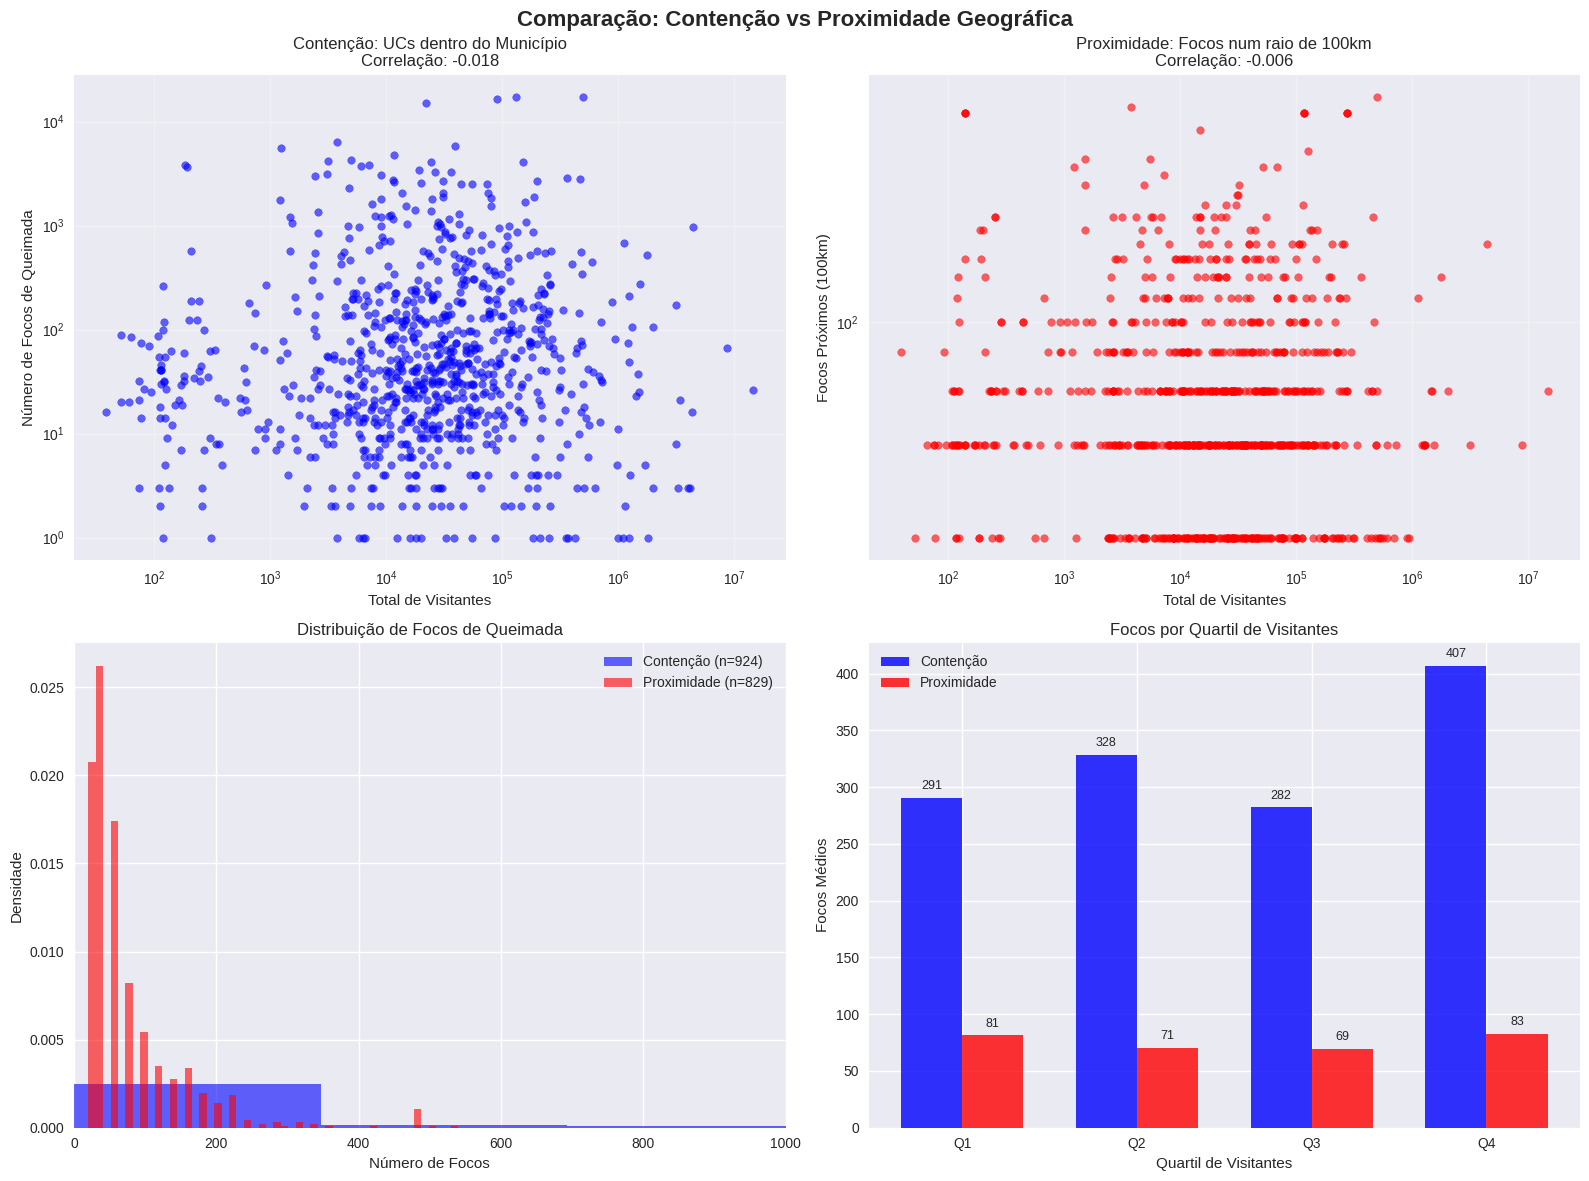


CONCLUSOES FINAIS - ANÁLISE KDD
PERGUNTA: Qual a relação entre as Unidades de Conservação federais
          perto dos municípios turísticos e as queimadas na região?

RESULTADOS:

1. ABORDAGEM DE CONTENCAO (UCs dentro do município):
   - 924 municípios turísticos com UCs
   - Correlação UCs-Turismo: 0.432 (MODERADA+)
   - Correlação UCs-Queimadas: 0.165 (FRACA+)
   - Correlação Turismo-Queimadas: -0.018 (MUITO FRACA)

2. ABORDAGEM DE PROXIMIDADE GEOGRAFICA (raio de 100km):
   - 829 municípios turísticos próximos a focos
   - Correlação Turismo-Queimadas: -0.006 (MUITO FRACA)
   - Distância média aos focos: 63.9km
   - Não há correlação significativa (p-value: 0.857)

INTERPRETACAO:
- A presença de UCs está moderadamente correlacionada com turismo
- UCs têm fraca correlação positiva com queimadas (podem atrair fiscalização)
- Proximidade geográfica não revela relação forte entre turismo e queimadas
- A relação é mais complexa, envolvendo fatores como bioma e gestão ambiental


In [24]:
# Visualização comparativa das duas abordagens
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparação: Contenção vs Proximidade Geográfica', fontsize=16, fontweight='bold')

# 1. Scatter plot - Abordagem de Contenção
ax1 = axes[0, 0]
scatter1 = ax1.scatter(dataset_final['TOTAL_VISITANTES'], dataset_final['NUM_FOCOS'],
                      alpha=0.6, c='blue', s=30)
ax1.set_xlabel('Total de Visitantes')
ax1.set_ylabel('Número de Focos de Queimada')
ax1.set_title(f'Contenção: UCs dentro do Município\nCorrelação: {correlacao_turismo_queimadas:.3f}')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# 2. Scatter plot - Abordagem de Proximidade
ax2 = axes[0, 1]
scatter2 = ax2.scatter(proximidade_completa['TOTAL_VISITANTES'], proximidade_completa['FOCOS_PROXIMOS_TOTAL'],
                      alpha=0.6, c='red', s=30)
ax2.set_xlabel('Total de Visitantes')
ax2.set_ylabel('Focos Próximos (100km)')
ax2.set_title(f'Proximidade: Focos num raio de 100km\nCorrelação: {corr_prox_turismo_queimadas:.3f}')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

# 3. Comparação de distribuições - Focos
ax3 = axes[1, 0]
ax3.hist(dataset_final['NUM_FOCOS'], bins=50, alpha=0.6, label=f'Contenção (n={len(dataset_final)})',
         color='blue', density=True)
ax3.hist(proximidade_completa['FOCOS_PROXIMOS_TOTAL'], bins=50, alpha=0.6,
         label=f'Proximidade (n={len(proximidade_completa)})', color='red', density=True)
ax3.set_xlabel('Número de Focos')
ax3.set_ylabel('Densidade')
ax3.set_title('Distribuição de Focos de Queimada')
ax3.legend()
ax3.set_xlim(0, 1000)

# 4. Comparação de quartis
ax4 = axes[1, 1]
quartis_contencao = []
quartis_proximidade = []
labels = ['Q1', 'Q2', 'Q3', 'Q4']

# Dados da análise de contenção (já calculados anteriormente)
visitantes_poucas_ucs = grupo_poucas_ucs['TOTAL_VISITANTES']
visitantes_muitas_ucs = grupo_muitas_ucs['TOTAL_VISITANTES']
quartis_contencao = [
    dataset_final[dataset_final['TOTAL_VISITANTES'] <= dataset_final['TOTAL_VISITANTES'].quantile(0.25)]['NUM_FOCOS'].mean(),
    dataset_final[(dataset_final['TOTAL_VISITANTES'] > dataset_final['TOTAL_VISITANTES'].quantile(0.25)) &
                  (dataset_final['TOTAL_VISITANTES'] <= dataset_final['TOTAL_VISITANTES'].quantile(0.5))]['NUM_FOCOS'].mean(),
    dataset_final[(dataset_final['TOTAL_VISITANTES'] > dataset_final['TOTAL_VISITANTES'].quantile(0.5)) &
                  (dataset_final['TOTAL_VISITANTES'] <= dataset_final['TOTAL_VISITANTES'].quantile(0.75))]['NUM_FOCOS'].mean(),
    dataset_final[dataset_final['TOTAL_VISITANTES'] > dataset_final['TOTAL_VISITANTES'].quantile(0.75)]['NUM_FOCOS'].mean()
]

# Dados da análise de proximidade
for q in ['Q1_Baixo', 'Q2_Medio-Baixo', 'Q3_Medio-Alto', 'Q4_Alto']:
    dados_q = proximidade_completa[proximidade_completa['QUARTIL_VISITANTES'] == q]
    quartis_proximidade.append(dados_q['FOCOS_PROXIMOS_TOTAL'].mean())

x = np.arange(len(labels))
width = 0.35

bars1 = ax4.bar(x - width/2, quartis_contencao, width, label='Contenção', alpha=0.8, color='blue')
bars2 = ax4.bar(x + width/2, quartis_proximidade, width, label='Proximidade', alpha=0.8, color='red')

ax4.set_xlabel('Quartil de Visitantes')
ax4.set_ylabel('Focos Médios')
ax4.set_title('Focos por Quartil de Visitantes')
ax4.set_xticks(x)
ax4.set_xticklabels(labels)
ax4.legend()

# Adicionar valores nas barras
for bar in bars1:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{height:.0f}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{height:.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Resumo final das descobertas
print("\n" + "="*80)
print("CONCLUSOES FINAIS - ANÁLISE KDD")
print("="*80)
print("PERGUNTA: Qual a relação entre as Unidades de Conservação federais")
print("          perto dos municípios turísticos e as queimadas na região?")
print()
print("RESULTADOS:")
print()
print("1. ABORDAGEM DE CONTENCAO (UCs dentro do município):")
print(f"   - {len(dataset_final)} municípios turísticos com UCs")
print(f"   - Correlação UCs-Turismo: {correlacao_ucs_visitantes:.3f} (MODERADA+)")
print(f"   - Correlação UCs-Queimadas: {correlacao_ucs_queimadas:.3f} (FRACA+)")
print(f"   - Correlação Turismo-Queimadas: {correlacao_turismo_queimadas:.3f} (MUITO FRACA)")
print()
print("2. ABORDAGEM DE PROXIMIDADE GEOGRAFICA (raio de 100km):")
print(f"   - {len(proximidade_completa)} municípios turísticos próximos a focos")
print(f"   - Correlação Turismo-Queimadas: {corr_prox_turismo_queimadas:.3f} (MUITO FRACA)")
print(f"   - Distância média aos focos: {proximidade_completa['DISTANCIA_MEDIA_FOCOS'].mean():.1f}km")
print(f"   - Não há correlação significativa (p-value: {p_value_prox:.3f})")
print()
print("INTERPRETACAO:")
print("- A presença de UCs está moderadamente correlacionada com turismo")
print("- UCs têm fraca correlação positiva com queimadas (podem atrair fiscalização)")
print("- Proximidade geográfica não revela relação forte entre turismo e queimadas")
print("- A relação é mais complexa, envolvendo fatores como bioma e gestão ambiental")
print("="*80)

# Salvando DATASET_FINAL para mineração de dados

In [25]:
# Salvar dataset final em CSV
if len(dataset_final) > 0:
    nome_arquivo = f"{DATASETS_PATH}dataset_final_ucs_turismo_queimadas.csv"
    dataset_final.to_csv(nome_arquivo, index=False, encoding='utf-8')
    print(f"Dataset salvo em: {nome_arquivo}")
    print(f"Registros salvos: {len(dataset_final)}")
    print(f"Colunas: {list(dataset_final.columns)}")
else:
    print("Dataset final está vazio - não foi possível salvar")

Dataset salvo em: ./datasets/dataset_final_ucs_turismo_queimadas.csv
Registros salvos: 924
Colunas: ['MUNICIPIO_CLEAN', 'UF', 'MUNICIPIO', 'QUANTIDADE_EMPREGOS', 'QUANTIDADE_ ESTABELECIMENTOS', 'QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL', 'QUANTIDADE_VISITAS_ESTIMADAS_ INTERNACIONAL', 'ARRECADACAO', 'NUM_UCS', 'BIOMAS_UCS', 'TOTAL_VISITANTES', 'Municipio_Clean', 'NUM_FOCOS', 'INTENSIDADE_MEDIA', 'INTENSIDADE_TOTAL', 'ANO_MIN', 'ANO_MAX', 'ESTADO_QUEIMADA', 'BIOMAS_QUEIMADA', 'CATEGORIA_UCS']
